In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Datasets/YogaPoseEstimation/Images/Yoga-30/dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset/train/cobra/cobra_images_144.png  
  inflating: dataset/train/cobra/cobra_images_145.png  
 extracting: dataset/train/cobra/cobra_images_146.png  
  inflating: dataset/train/cobra/cobra_images_147.png  
 extracting: dataset/train/cobra/cobra_images_148.png  
  inflating: dataset/train/cobra/cobra_images_149.png  
  inflating: dataset/train/cobra/cobra_images_15.png  
 extracting: dataset/train/cobra/cobra_images_150.png  
  inflating: dataset/train/cobra/cobra_images_151.png  
 extracting: dataset/train/cobra/cobra_images_152.png  
  inflating: dataset/train/cobra/cobra_images_153.png  
 extracting: dataset/train/cobra/cobra_images_154.png  
  inflating: dataset/train/cobra/cobra_images_155.png  
 extracting: dataset/train/cobra/cobra_images_156.png  
  inflating: dataset/train/cobra/cobra_images_157.png  
 extracting: dataset/train/cobra/cobra_images_158.png  
  inflating: dataset/train/cobra/cobra_images_159.png 

In [3]:
!pip install mediapipe
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.3/716.3 kB 14.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import csv
import itertools
import sys
import tempfile
import tqdm
import zipfile
import pickle
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns
import mediapipe as mp
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from pydantic import BaseModel
from PIL import Image
import glob

In [5]:
dataset_name = 'Yoga-30 Dataset'
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'
path_to_save = '/content/drive/MyDrive/Datasets/YogaPoseEstimation/Images/Yoga-30/'

In [6]:
def load_and_preprocess_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.keras.applications.xception.preprocess_input(img)
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {str(e)}")
        return None


def create_df(dir):
    df = pd.DataFrame(columns=['image_path', 'class_name', 'class_no', 'image'])
    class_names = sorted(os.listdir(dir))
    for class_name in class_names:
        class_path = os.path.join(dir, class_name)
        class_no = class_names.index(class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = load_and_preprocess_image(image_path)
            if img is not None:
                df.loc[len(df)] = [image_path, class_name, class_no, img]
            else:
                continue

    return df

def load_data(df):
    df.drop(columns=['image_path'], inplace=True)
    classes = df.pop('class_name').unique()
    x_images = df.pop('image')
    y = df.pop('class_no')
    y = keras.utils.to_categorical(y)
    return x_images, y, classes, df

train_df = create_df(train_dir)
test_df = create_df(test_dir)

X_train, y_train, classes, _ = load_data(train_df)
X_test, y_test, _, _ = load_data(test_df)

X_train = np.stack(X_train.values)
X_test = np.stack(X_test.values)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Error loading image /content/dataset/train/downdog/downdog_images_265.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_143.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_268.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_93.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [

In [7]:
xception_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
xception_model.trainable = False

model = tf.keras.Sequential([
    xception_model,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 256)               52429056  
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16

In [8]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint_pth = "weights_Xception.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_pth, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/50
198/198 [==============================] - ETA: 0s - loss: 3.0620 - accuracy: 0.2024
Epoch 1: val_accuracy improved from -inf to 0.68961, saving model to weights_Xception.keras
198/198 [==============================] - 31s 113ms/step - loss: 3.0620 - accuracy: 0.2024 - val_loss: 1.3077 - val_accuracy: 0.6896
Epoch 2/50
197/198 [============================>.] - ETA: 0s - loss: 1.8500 - accuracy: 0.4535
Epoch 2: val_accuracy improved from 0.68961 to 0.79787, saving model to weights_Xception.keras
198/198 [==============================] - 18s 93ms/step - loss: 1.8483 - accuracy: 0.4543 - val_loss: 0.9668 - val_accuracy: 0.7979
Epoch 3/50
197/198 [============================>.] - ETA: 0s - loss: 1.3384 - accuracy: 0.6102
Epoch 3: val_accuracy improved from 0.79787 to 0.85044, saving model to weights_Xception.keras
198/198 [==============================] - 18s 91ms/step - loss: 1.3382 - accuracy: 0.6103 - val_loss: 0.7110 - val_accuracy: 0.8504
Epoch 4/50
197/198 [==========

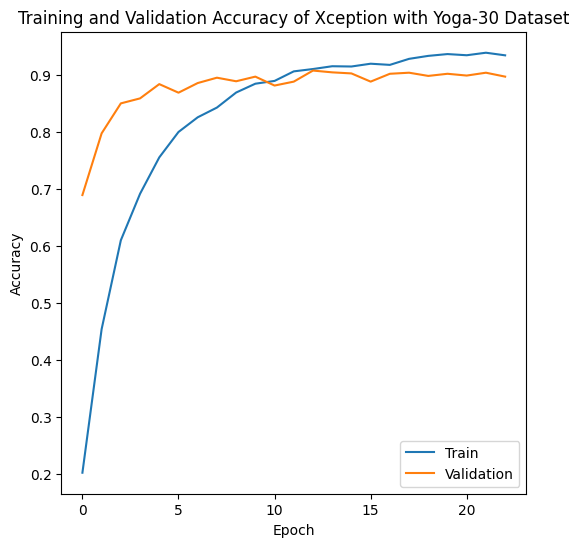

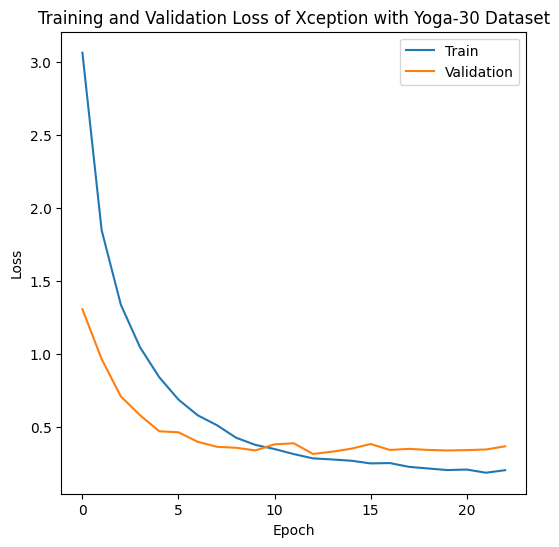

In [9]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Training and Validation Accuracy of Xception with {dataset_name}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('Accuracy_Graph_Xception.png')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Training and Validation Loss of Xception with {dataset_name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Loss_Graph_Xception.png')
plt.show()

In [10]:
model = tf.keras.models.load_model("weights_Xception.keras")
model.evaluate(X_test, y_test)

50/50 [==============================] - 4s 58ms/step - loss: 0.3177 - accuracy: 0.9080


[0.3176662027835846, 0.9080100059509277]

50/50 [==============================] - 3s 55ms/step


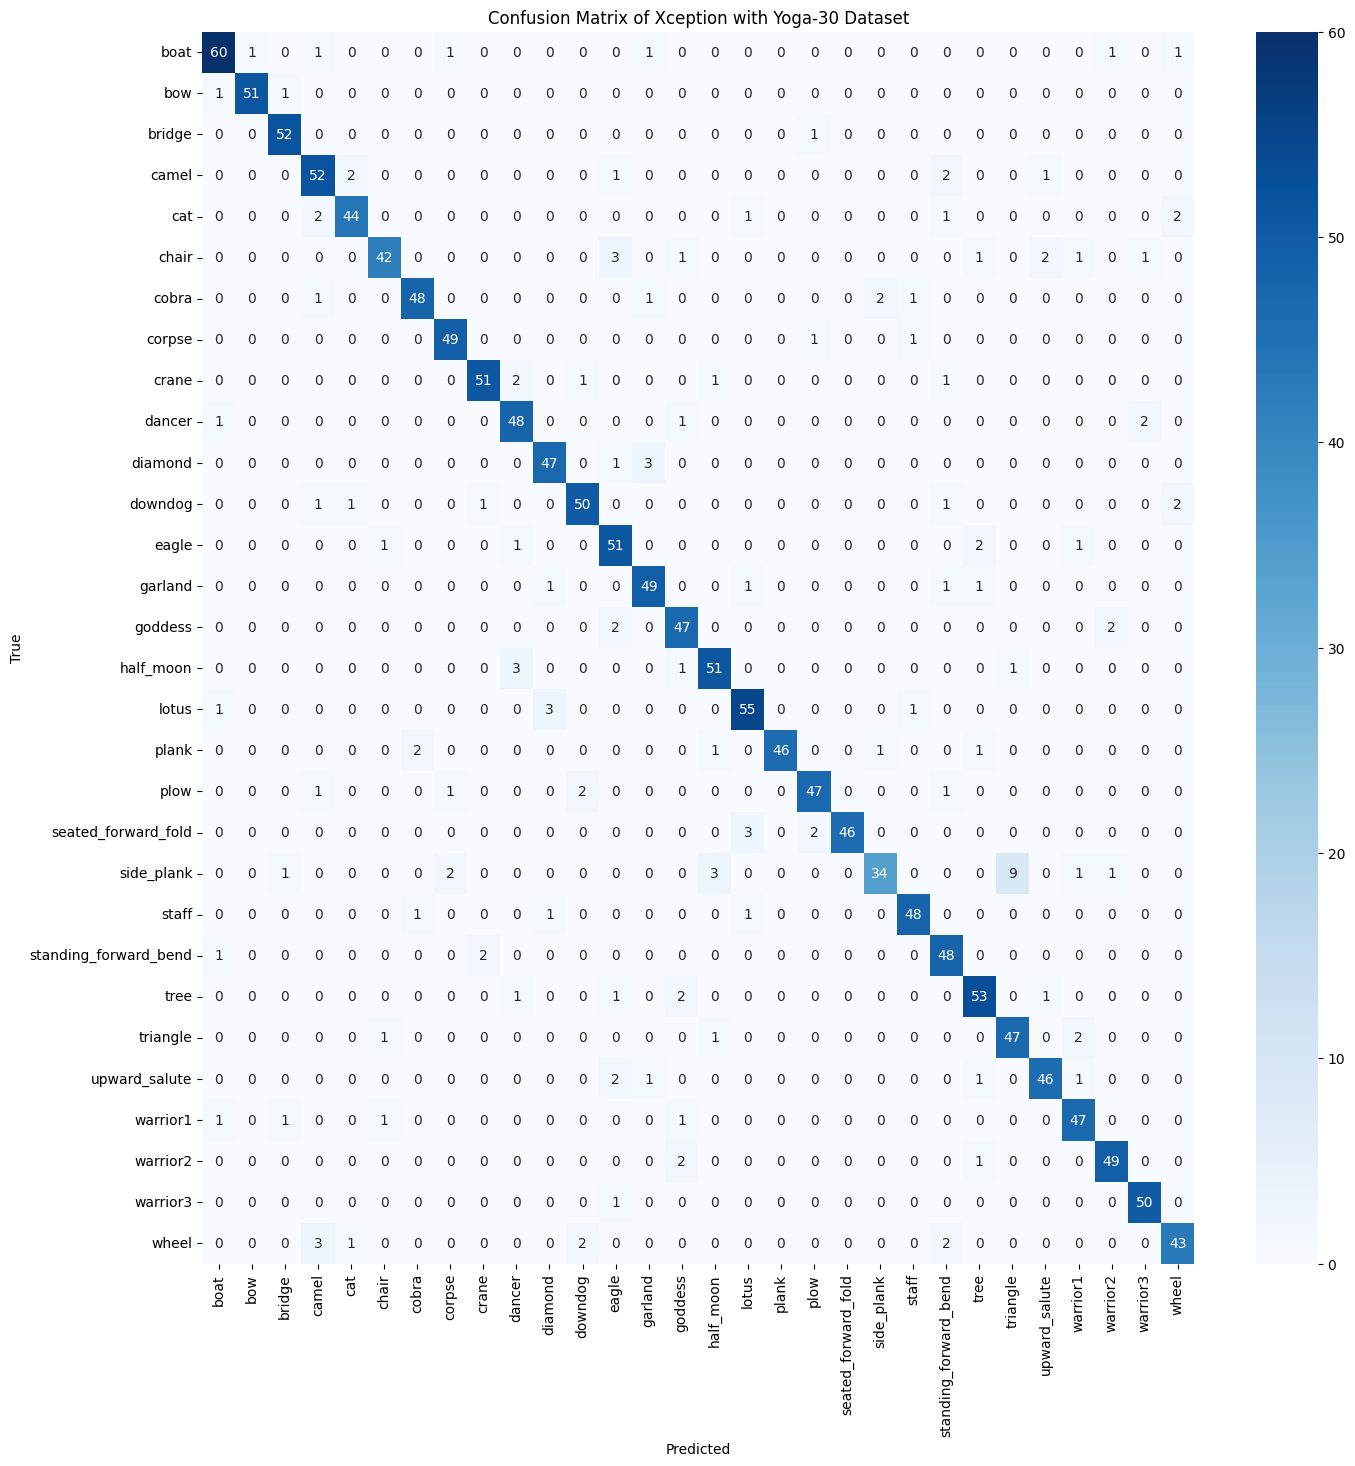

                       precision    recall  f1-score   support

                 boat       0.92      0.91      0.92        66
                  bow       0.98      0.96      0.97        53
               bridge       0.95      0.98      0.96        53
                camel       0.85      0.90      0.87        58
                  cat       0.92      0.88      0.90        50
                chair       0.93      0.82      0.87        51
                cobra       0.94      0.91      0.92        53
               corpse       0.92      0.96      0.94        51
                crane       0.94      0.91      0.93        56
               dancer       0.87      0.92      0.90        52
              diamond       0.90      0.92      0.91        51
              downdog       0.91      0.89      0.90        56
                eagle       0.82      0.91      0.86        56
              garland       0.89      0.92      0.91        53
              goddess       0.85      0.92      0.89  

In [12]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of Xception with {dataset_name}')
plt.savefig('Confusion_Matrix_Xception.png')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=classes)
print(class_report)

In [13]:
import zipfile
import os
import pickle

with open('history_for_Xception.pkl', 'wb') as f:
    pickle.dump(history, f)

def create_zip(files_to_zip, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in files_to_zip:
            # Add the file to the zip archive
            zipf.write(file, os.path.basename(file))

# Example: List of files to be included in the zip
files_to_zip = ['Accuracy_Graph_Xception.png', 'Loss_Graph_Xception.png', 'history_for_Xception.pkl', 'weights_Xception.keras', 'Confusion_Matrix_Xception.png']

# Specify the name of the zip file
zip_filename = 'results_Xception.zip'

# Create the zip file
create_zip(files_to_zip, zip_filename)


In [14]:
!cp {zip_filename} {path_to_save}

# EfficientNetB0 Model

In [15]:
def load_and_preprocess_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {str(e)}")
        return None


def create_df(dir):
    df = pd.DataFrame(columns=['image_path', 'class_name', 'class_no', 'image'])
    class_names = sorted(os.listdir(dir))
    for class_name in class_names:
        class_path = os.path.join(dir, class_name)
        class_no = class_names.index(class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = load_and_preprocess_image(image_path)
            if img is not None:
                df.loc[len(df)] = [image_path, class_name, class_no, img]
            else:
                continue
    return df

def load_data(df):
    df.drop(columns=['image_path'], inplace=True)
    classes = df.pop('class_name').unique()
    x_images = df.pop('image')
    y = df.pop('class_no')
    y = keras.utils.to_categorical(y)
    return x_images, y, classes, df


train_df = create_df(train_dir)
test_df = create_df(test_dir)

X_train, y_train, classes, _ = load_data(train_df)
X_test, y_test, _, _ = load_data(test_df)

X_train = np.stack(X_train.values)
X_test = np.stack(X_test.values)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Error loading image /content/dataset/train/downdog/downdog_images_265.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_143.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_268.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_93.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [

In [16]:
efficient_net_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficient_net_model.trainable = False

model = tf.keras.Sequential([
    efficient_net_model,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               16056576  
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                       

In [17]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint_pth = "weights_EfficientNetB0.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_pth, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/50
198/198 [==============================] - ETA: 0s - loss: 2.0783 - accuracy: 0.4264
Epoch 1: val_accuracy improved from -inf to 0.85106, saving model to weights_EfficientNetB0.keras
198/198 [==============================] - 19s 52ms/step - loss: 2.0783 - accuracy: 0.4264 - val_loss: 0.6136 - val_accuracy: 0.8511
Epoch 2/50
197/198 [============================>.] - ETA: 0s - loss: 0.9335 - accuracy: 0.7557
Epoch 2: val_accuracy improved from 0.85106 to 0.91927, saving model to weights_EfficientNetB0.keras
198/198 [==============================] - 8s 39ms/step - loss: 0.9325 - accuracy: 0.7560 - val_loss: 0.3787 - val_accuracy: 0.9193
Epoch 3/50
198/198 [==============================] - ETA: 0s - loss: 0.5496 - accuracy: 0.8609
Epoch 3: val_accuracy improved from 0.91927 to 0.93054, saving model to weights_EfficientNetB0.keras
198/198 [==============================] - 8s 39ms/step - loss: 0.5496 - accuracy: 0.8609 - val_loss: 0.2901 - val_accuracy: 0.9305
Epoch 4/50
196/

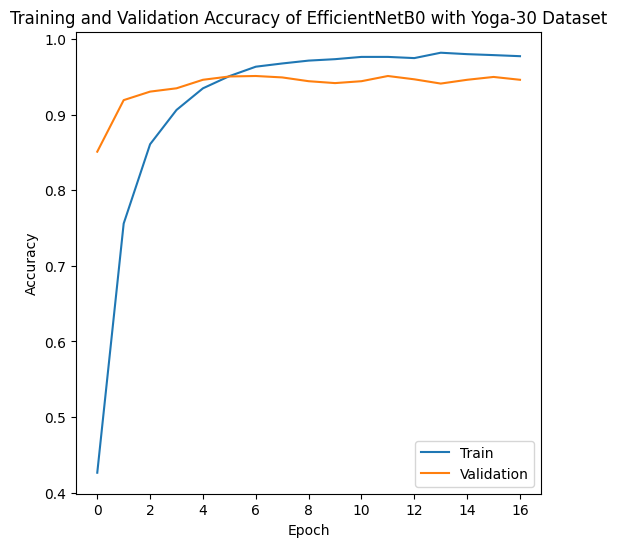

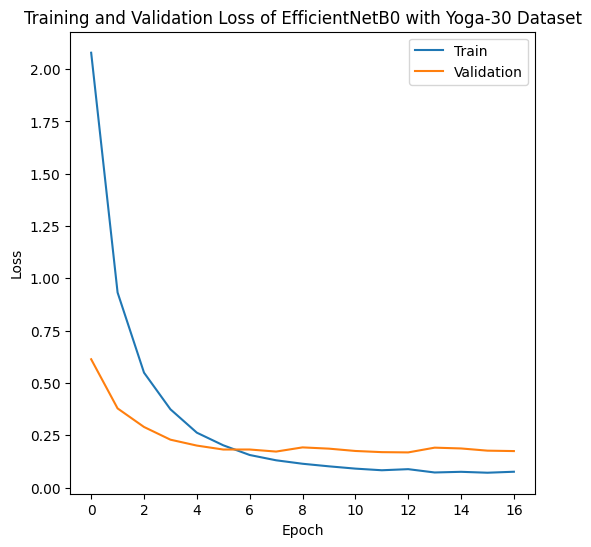

In [18]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Training and Validation Accuracy of EfficientNetB0 with {dataset_name}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('Accuracy_Graph_EfficientNetB0.png')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Training and Validation Loss of EfficientNetB0 with {dataset_name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Loss_Graph_EfficientNetB0.png')
plt.show()

In [19]:
model = tf.keras.models.load_model('weights_EfficientNetB0.keras')
model.evaluate(X_test, y_test)

50/50 [==============================] - 4s 23ms/step - loss: 0.1824 - accuracy: 0.9512


[0.1823531538248062, 0.9511889815330505]

50/50 [==============================] - 1s 20ms/step


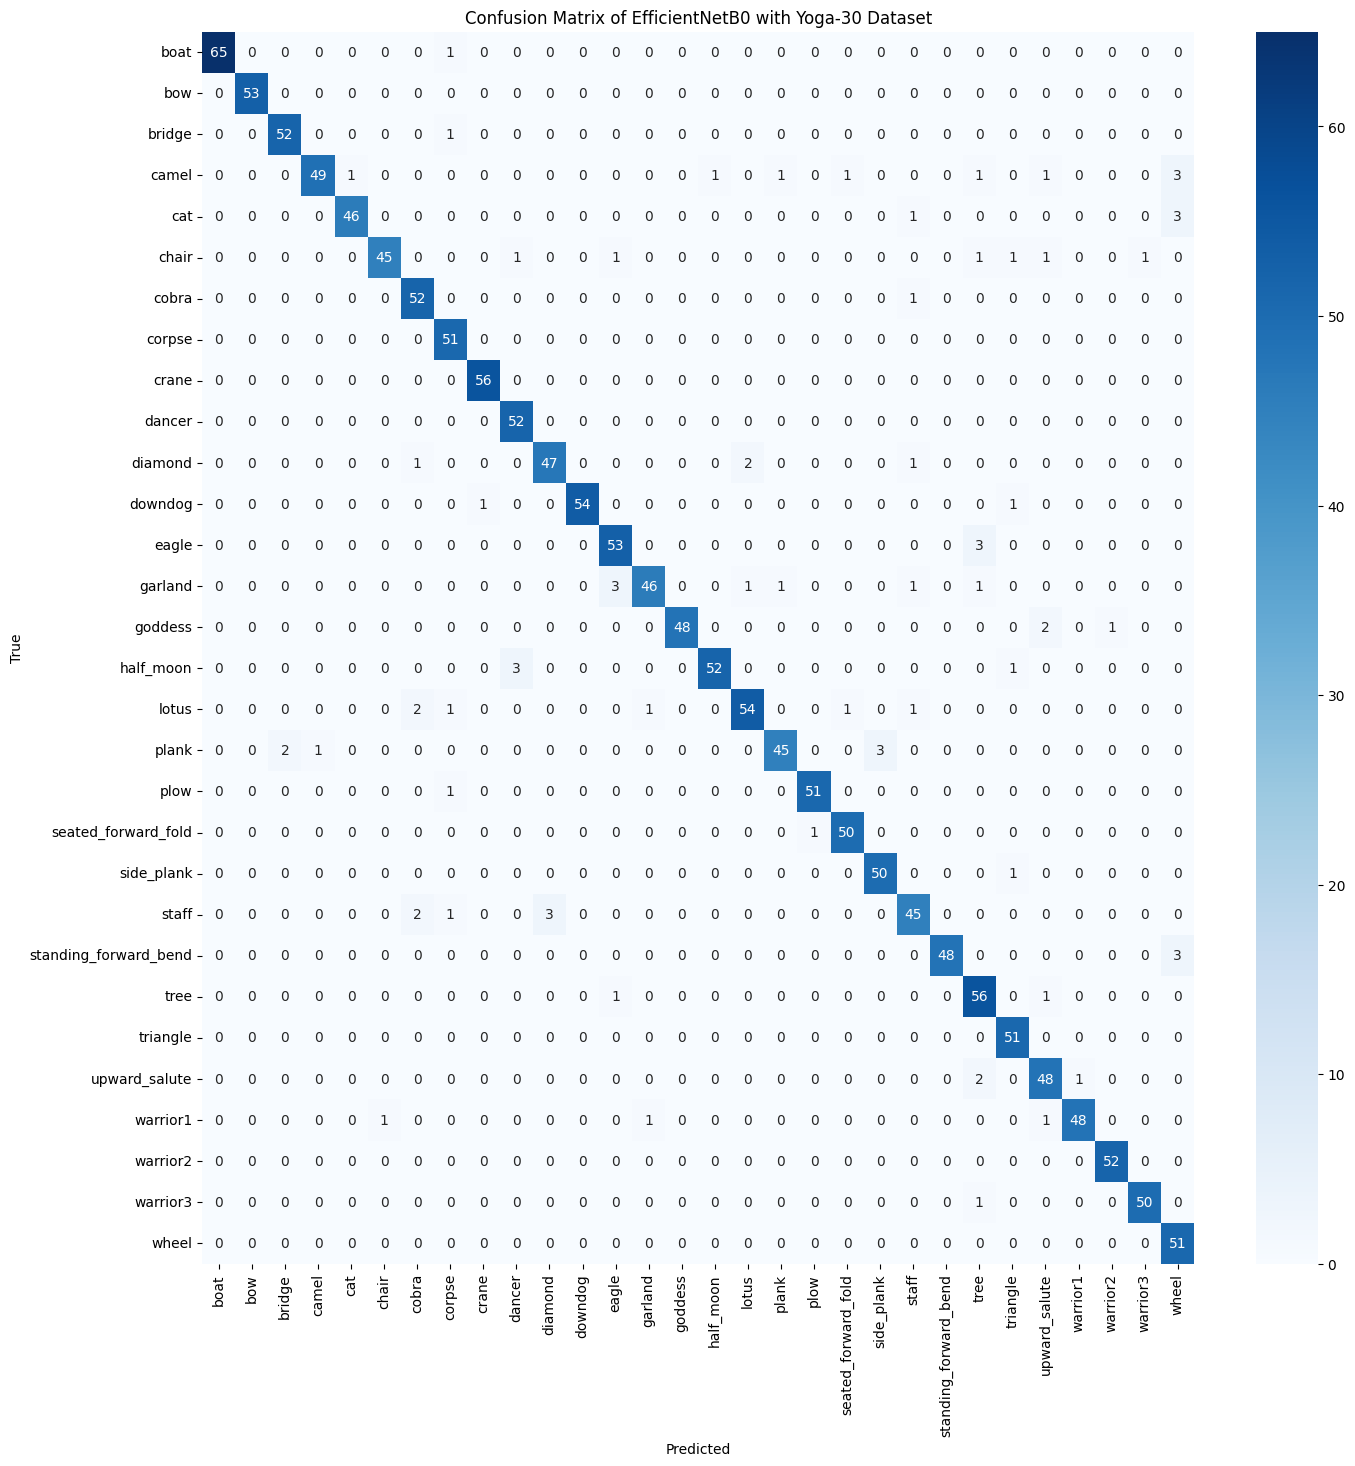

                       precision    recall  f1-score   support

                 boat       1.00      0.98      0.99        66
                  bow       1.00      1.00      1.00        53
               bridge       0.96      0.98      0.97        53
                camel       0.98      0.84      0.91        58
                  cat       0.98      0.92      0.95        50
                chair       0.98      0.88      0.93        51
                cobra       0.91      0.98      0.95        53
               corpse       0.91      1.00      0.95        51
                crane       0.98      1.00      0.99        56
               dancer       0.93      1.00      0.96        52
              diamond       0.94      0.92      0.93        51
              downdog       1.00      0.96      0.98        56
                eagle       0.91      0.95      0.93        56
              garland       0.96      0.87      0.91        53
              goddess       1.00      0.94      0.97  

In [21]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of EfficientNetB0 with {dataset_name}')
plt.savefig('Confusion_Matrix_EfficientNetB0.png')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=classes)
print(class_report)

In [22]:
with open('history_for_EfficientNetB0.pkl', 'wb') as f:
    pickle.dump(history.history, f)

files_to_zip = ['weights_EfficientNetB0.keras', 'history_for_EfficientNetB0.pkl', 'Confusion_Matrix_EfficientNetB0.png', 'Loss_Graph_EfficientNetB0.png', 'Accuracy_Graph_EfficientNetB0.png']
zip_filename = 'results_EfficientNetB0.zip'

create_zip(files_to_zip, zip_filename)

In [23]:
!cp {zip_filename} {path_to_save}

# Inception-V3

In [24]:
def load_and_preprocess_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {str(e)}")
        return None


def create_df(dir):
    df = pd.DataFrame(columns=['image_path', 'class_name', 'class_no', 'image'])
    class_names = sorted(os.listdir(dir))
    for class_name in class_names:
        class_path = os.path.join(dir, class_name)
        class_no = class_names.index(class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = load_and_preprocess_image(image_path)
            if img is not None:
                df.loc[len(df)] = [image_path, class_name, class_no, img]
            else:
                continue
    return df


def load_data(df):
    df.drop(columns=['image_path'], inplace=True)
    classes = df.pop('class_name').unique()
    x_images = df.pop('image')
    y = df.pop('class_no')
    y = keras.utils.to_categorical(y)
    return x_images, y, classes, df


train_df = create_df(train_dir)
test_df = create_df(test_dir)

X_train, y_train, classes, _ = load_data(train_df)
X_test, y_test, _, _ = load_data(test_df)

X_train = np.stack(X_train.values)
X_test = np.stack(X_test.values)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Error loading image /content/dataset/train/downdog/downdog_images_265.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_143.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_268.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_93.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [

In [25]:
inception_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model.trainable = False

model = tf.keras.Sequential([
    inception_model,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

87910968/87910968 [==============================] - 6s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               13107456  
                                                                 
 batch_normalization_102 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                

In [26]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint_pth = "weights_InceptionV3.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_pth, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/50
198/198 [==============================] - ETA: 0s - loss: 2.5485 - accuracy: 0.3121
Epoch 1: val_accuracy improved from -inf to 0.72215, saving model to weights_InceptionV3.keras
198/198 [==============================] - 19s 61ms/step - loss: 2.5485 - accuracy: 0.3121 - val_loss: 1.1268 - val_accuracy: 0.7222
Epoch 2/50
198/198 [==============================] - ETA: 0s - loss: 1.3424 - accuracy: 0.6233
Epoch 2: val_accuracy improved from 0.72215 to 0.77222, saving model to weights_InceptionV3.keras
198/198 [==============================] - 7s 38ms/step - loss: 1.3424 - accuracy: 0.6233 - val_loss: 0.8570 - val_accuracy: 0.7722
Epoch 3/50
196/198 [============================>.] - ETA: 0s - loss: 0.9392 - accuracy: 0.7377
Epoch 3: val_accuracy improved from 0.77222 to 0.81227, saving model to weights_InceptionV3.keras
198/198 [==============================] - 8s 41ms/step - loss: 0.9403 - accuracy: 0.7372 - val_loss: 0.6770 - val_accuracy: 0.8123
Epoch 4/50
197/198 [====

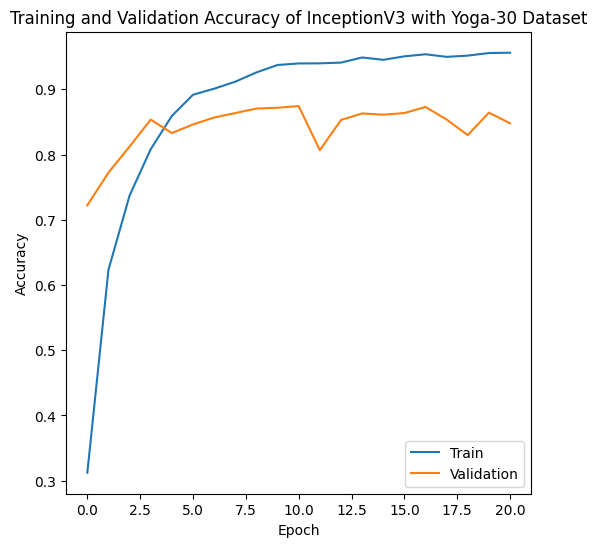

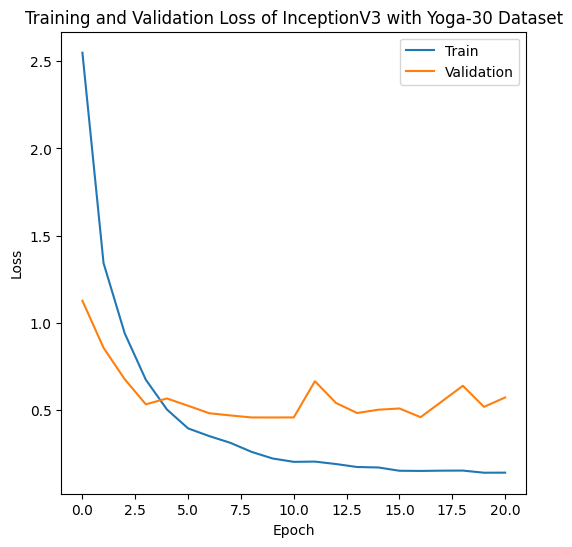

In [27]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Training and Validation Accuracy of InceptionV3 with {dataset_name}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('Accuracy_Graph_InceptionV3.png')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Training and Validation Loss of InceptionV3 with {dataset_name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Loss_Graph_InceptionV3.png')
plt.show()

In [28]:
model = tf.keras.models.load_model('weights_InceptionV3.keras')
model.evaluate(X_test, y_test)

50/50 [==============================] - 3s 20ms/step - loss: 0.4579 - accuracy: 0.8742


[0.4579147696495056, 0.8742177486419678]

50/50 [==============================] - 1s 18ms/step


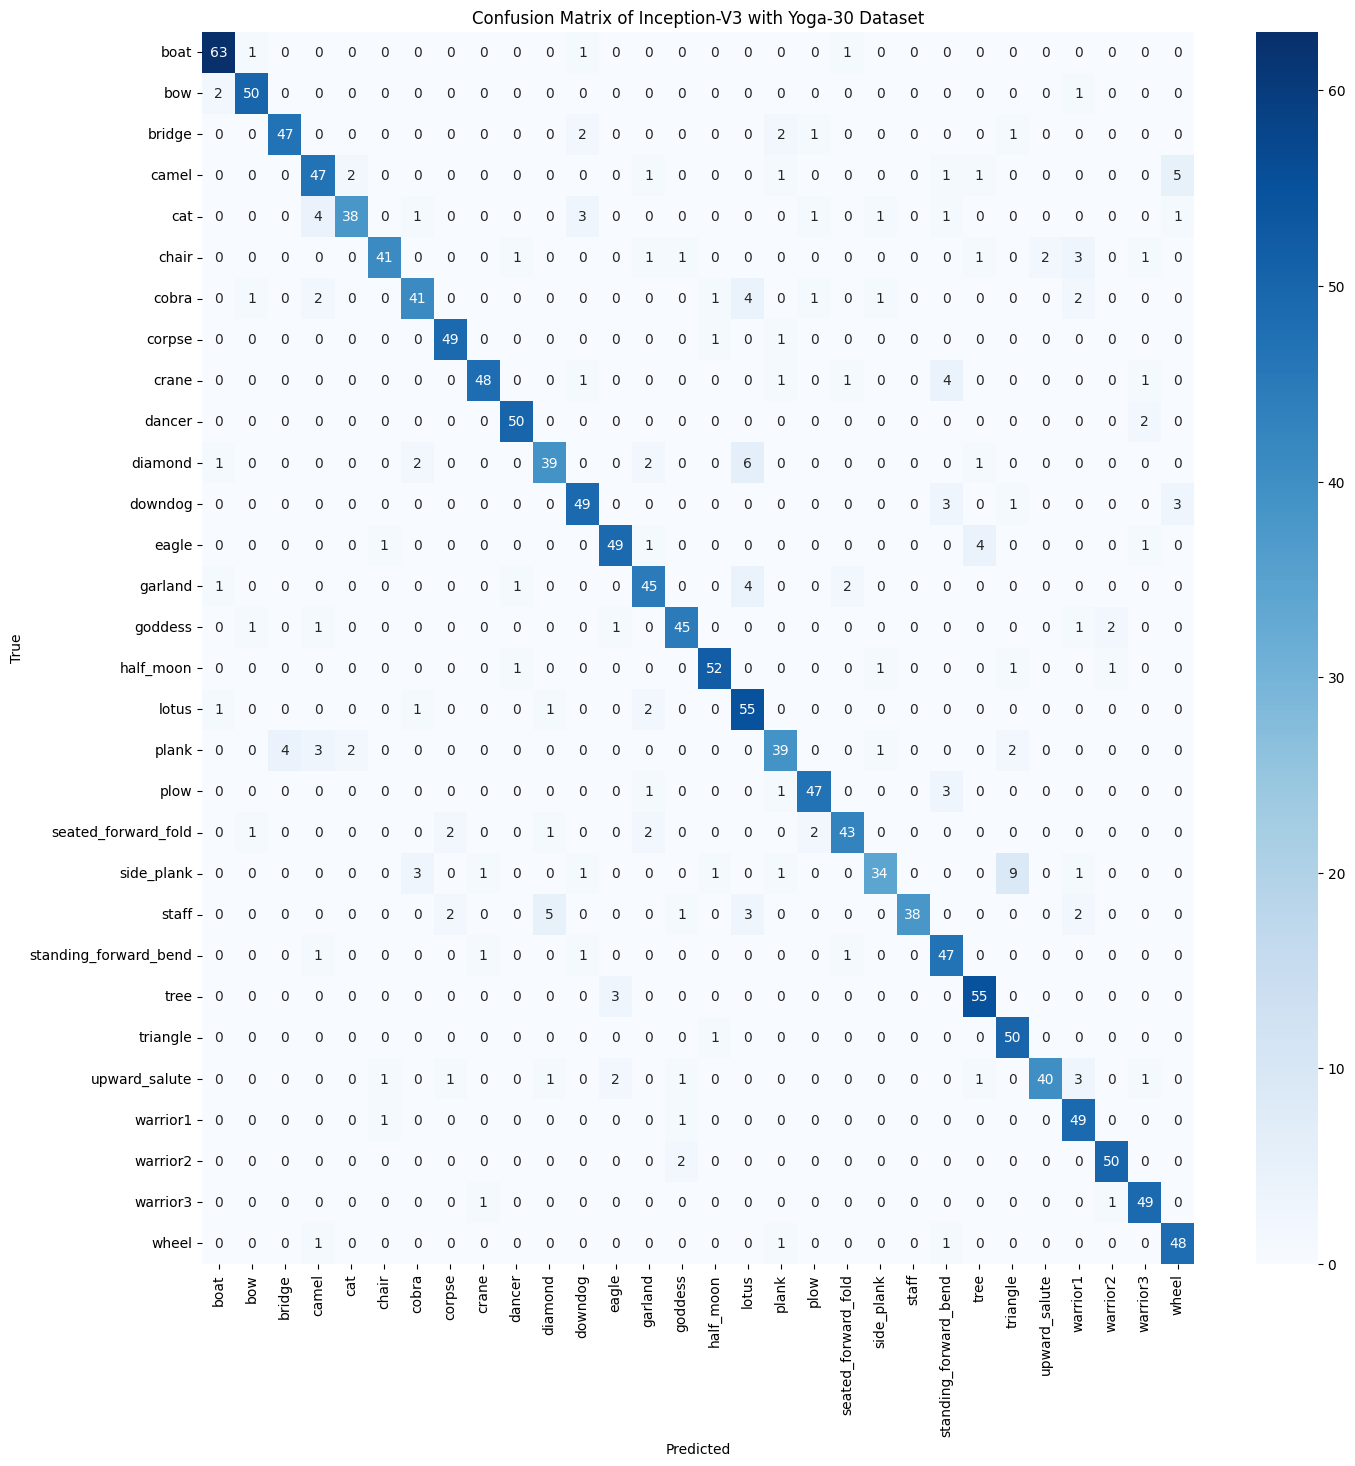

                       precision    recall  f1-score   support

                 boat       0.93      0.95      0.94        66
                  bow       0.93      0.94      0.93        53
               bridge       0.92      0.89      0.90        53
                camel       0.80      0.81      0.80        58
                  cat       0.90      0.76      0.83        50
                chair       0.93      0.80      0.86        51
                cobra       0.85      0.77      0.81        53
               corpse       0.91      0.96      0.93        51
                crane       0.94      0.86      0.90        56
               dancer       0.94      0.96      0.95        52
              diamond       0.83      0.76      0.80        51
              downdog       0.84      0.88      0.86        56
                eagle       0.89      0.88      0.88        56
              garland       0.82      0.85      0.83        53
              goddess       0.88      0.88      0.88  

In [30]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of Inception-V3 with {dataset_name}')
plt.savefig('Confusion_Matrix_InceptionV3.png')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=classes)
print(class_report)

In [31]:
with open('history_InceptionV3.pkl', 'wb') as f:
    pickle.dump(history.history, f)

files_to_zip = ['Accuracy_Graph_InceptionV3.png', 'Loss_Graph_InceptionV3.png', 'Confusion_Matrix_InceptionV3.png', 'history_InceptionV3.pkl', 'weights_InceptionV3.keras']
zip_filename = "results_InceptionV3.zip"
create_zip(files_to_zip, zip_filename)

In [32]:
!cp {zip_filename} {path_to_save}

# MobileNet v2 Model

In [33]:
def load_and_preprocess_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {str(e)}")
        return None


def create_df(dir):
    df = pd.DataFrame(columns=['image_path', 'class_name', 'class_no', 'image'])
    class_names = sorted(os.listdir(dir))
    for class_name in class_names:
        class_path = os.path.join(dir, class_name)
        class_no = class_names.index(class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = load_and_preprocess_image(image_path)
            if img is not None:
                df.loc[len(df)] = [image_path, class_name, class_no, img]
            else:
                continue
    return df


def load_data(df):
    df.drop(columns=['image_path'], inplace=True)
    classes = df.pop('class_name').unique()
    x_images = df.pop('image')
    y = df.pop('class_no')
    y = keras.utils.to_categorical(y)
    return x_images, y, classes, df


train_df = create_df(train_dir)
test_df = create_df(test_dir)

X_train, y_train, classes, _ = load_data(train_df)
X_test, y_test, _, _ = load_data(test_df)

X_train = np.stack(X_train.values)
X_test = np.stack(X_test.values)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Error loading image /content/dataset/train/downdog/downdog_images_265.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_143.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_268.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_93.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [

In [34]:
mobile_net = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobile_net.trainable = False

model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               16056576  
                                                                 
 batch_normalization_104 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                         

In [35]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint_pth = "weights_MobileNetV2.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_pth, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/50
196/198 [============================>.] - ETA: 0s - loss: 2.1866 - accuracy: 0.3972
Epoch 1: val_accuracy improved from -inf to 0.83041, saving model to weights_MobileNetV2.keras
198/198 [==============================] - 11s 37ms/step - loss: 2.1825 - accuracy: 0.3979 - val_loss: 0.7651 - val_accuracy: 0.8304
Epoch 2/50
198/198 [==============================] - ETA: 0s - loss: 0.9862 - accuracy: 0.7361
Epoch 2: val_accuracy improved from 0.83041 to 0.89111, saving model to weights_MobileNetV2.keras
198/198 [==============================] - 6s 29ms/step - loss: 0.9862 - accuracy: 0.7361 - val_loss: 0.4567 - val_accuracy: 0.8911
Epoch 3/50
196/198 [============================>.] - ETA: 0s - loss: 0.5664 - accuracy: 0.8610
Epoch 3: val_accuracy improved from 0.89111 to 0.90989, saving model to weights_MobileNetV2.keras
198/198 [==============================] - 6s 28ms/step - loss: 0.5664 - accuracy: 0.8606 - val_loss: 0.3795 - val_accuracy: 0.9099
Epoch 4/50
196/198 [====

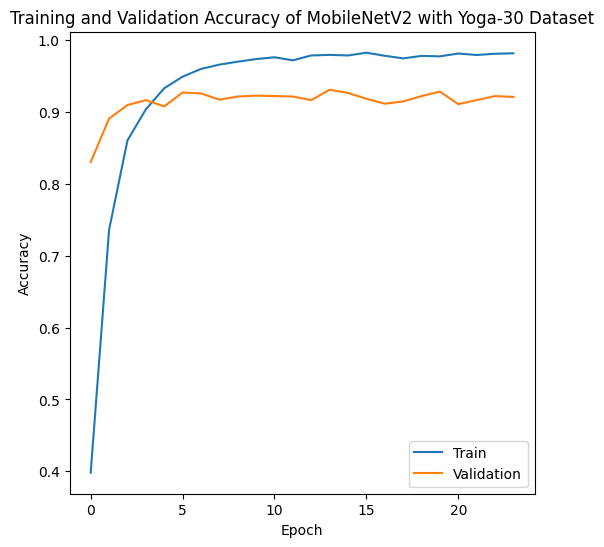

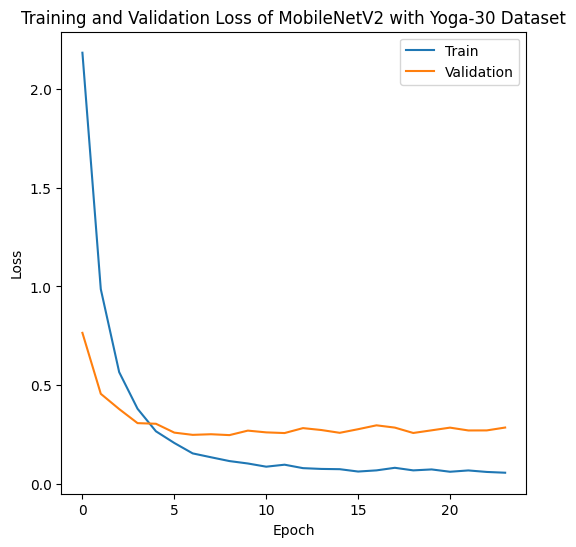

In [36]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Training and Validation Accuracy of MobileNetV2 with {dataset_name}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('Accuracy_Graph_MobileNetV2.png')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Training and Validation Loss of MobileNetV2 with {dataset_name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Loss_Graph_MobileNetV2.png')
plt.show()

In [37]:
model = tf.keras.models.load_model("weights_MobileNetV2.keras")
model.evaluate(X_test, y_test)

50/50 [==============================] - 2s 16ms/step - loss: 0.2735 - accuracy: 0.9312


[0.27348777651786804, 0.9311639666557312]

50/50 [==============================] - 2s 13ms/step


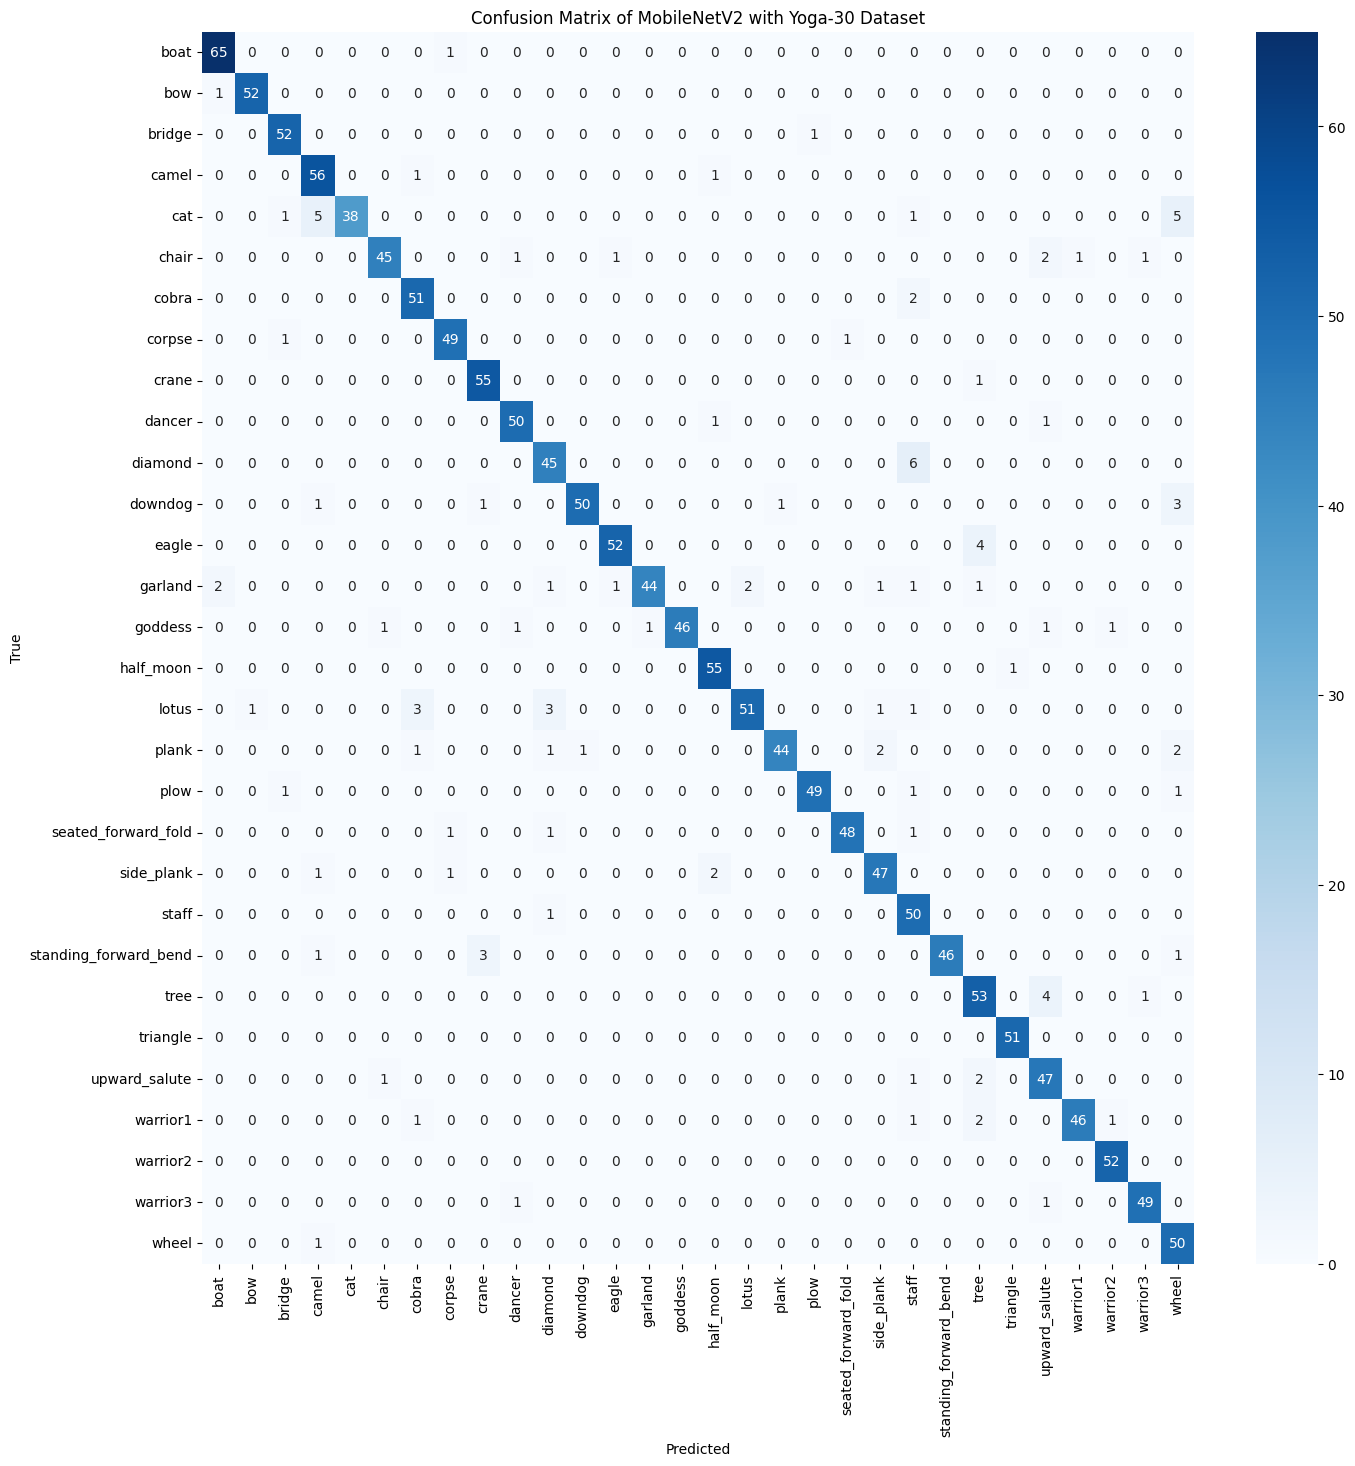

                       precision    recall  f1-score   support

                 boat       0.96      0.98      0.97        66
                  bow       0.98      0.98      0.98        53
               bridge       0.95      0.98      0.96        53
                camel       0.86      0.97      0.91        58
                  cat       1.00      0.76      0.86        50
                chair       0.96      0.88      0.92        51
                cobra       0.89      0.96      0.93        53
               corpse       0.94      0.96      0.95        51
                crane       0.93      0.98      0.96        56
               dancer       0.94      0.96      0.95        52
              diamond       0.87      0.88      0.87        51
              downdog       0.98      0.89      0.93        56
                eagle       0.96      0.93      0.95        56
              garland       0.98      0.83      0.90        53
              goddess       1.00      0.90      0.95  

In [38]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of MobileNetV2 with {dataset_name}')
plt.savefig('Confusion_Matrix_MobileNetV2.png')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=classes)
print(class_report)

In [39]:
with open('history_for_MoblieNetV2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

files_to_zip = ['weights_MobileNetV2.keras', 'history_for_MoblieNetV2.pkl', 'Loss_Graph_MobileNetV2.png', 'Accuracy_Graph_MobileNetV2.png', 'Confusion_Matrix_MobileNetV2.png']
zip_filename = 'results_MobileNetV2.zip'
create_zip(files_to_zip, zip_filename)


In [40]:
!cp {zip_filename} {path_to_save}

# ResNet50 Model

In [41]:
def load_and_preprocess_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.keras.applications.resnet50.preprocess_input(img)
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {str(e)}")
        return None


def create_df(dir):
    df = pd.DataFrame(columns=['image_path', 'class_name', 'class_no', 'image'])
    class_names = sorted(os.listdir(dir))
    for class_name in class_names:
        class_path = os.path.join(dir, class_name)
        class_no = class_names.index(class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = load_and_preprocess_image(image_path)
            if img is not None:
                df.loc[len(df)] = [image_path, class_name, class_no, img]
            else:
                continue
    return df


def load_data(df):
    df.drop(columns=['image_path'], inplace=True)
    classes = df.pop('class_name').unique()
    x_images = df.pop('image')
    y = df.pop('class_no')
    y = keras.utils.to_categorical(y)
    return x_images, y, classes, df


train_df = create_df(train_dir)
test_df = create_df(test_dir)

X_train, y_train, classes, _ = load_data(train_df)
X_test, y_test, _, _ = load_data(test_df)

X_train = np.stack(X_train.values)
X_test = np.stack(X_test.values)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Error loading image /content/dataset/train/downdog/downdog_images_265.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_143.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_268.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_93.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [

In [42]:
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False

model = tf.keras.Sequential([
    resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               25690368  
                                                                 
 batch_normalization_106 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                

In [43]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint_pth = "weights_ResNet50.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_pth, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/50
198/198 [==============================] - ETA: 0s - loss: 2.1313 - accuracy: 0.4245
Epoch 1: val_accuracy improved from -inf to 0.84981, saving model to weights_ResNet50.keras
198/198 [==============================] - 17s 60ms/step - loss: 2.1313 - accuracy: 0.4245 - val_loss: 0.6501 - val_accuracy: 0.8498
Epoch 2/50
197/198 [============================>.] - ETA: 0s - loss: 0.8887 - accuracy: 0.7778
Epoch 2: val_accuracy improved from 0.84981 to 0.91114, saving model to weights_ResNet50.keras
198/198 [==============================] - 9s 45ms/step - loss: 0.8878 - accuracy: 0.7781 - val_loss: 0.3937 - val_accuracy: 0.9111
Epoch 3/50
197/198 [============================>.] - ETA: 0s - loss: 0.4909 - accuracy: 0.8869
Epoch 3: val_accuracy improved from 0.91114 to 0.92804, saving model to weights_ResNet50.keras
198/198 [==============================] - 9s 45ms/step - loss: 0.4911 - accuracy: 0.8867 - val_loss: 0.2928 - val_accuracy: 0.9280
Epoch 4/50
197/198 [=============

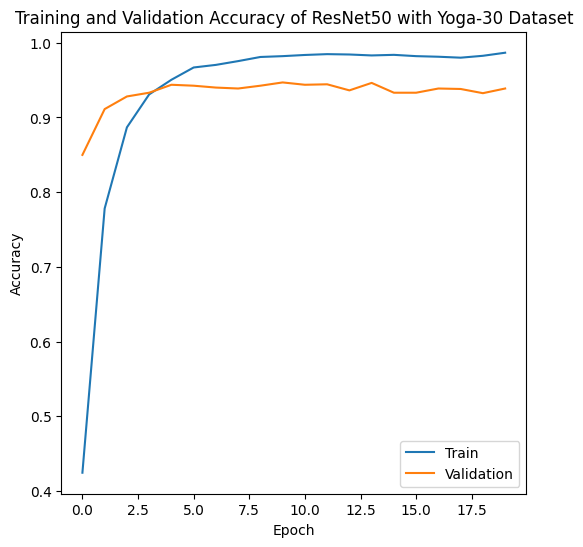

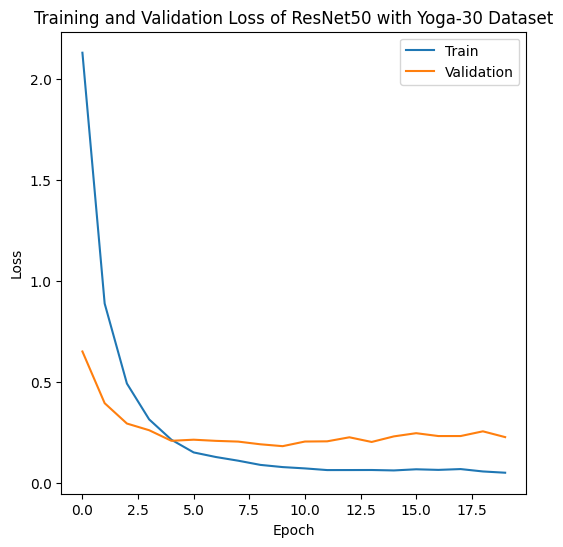

In [44]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Training and Validation Accuracy of ResNet50 with {dataset_name}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('Accuracy_Graph_ResNet50.png')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Training and Validation Loss of ResNet50 with {dataset_name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Loss_Graph_ResNet50.png')
plt.show()

In [45]:
model = keras.models.load_model('weights_ResNet50.keras')
model.evaluate(X_test, y_test)

50/50 [==============================] - 3s 25ms/step - loss: 0.1806 - accuracy: 0.9468


[0.1806166023015976, 0.9468085169792175]

50/50 [==============================] - 2s 23ms/step


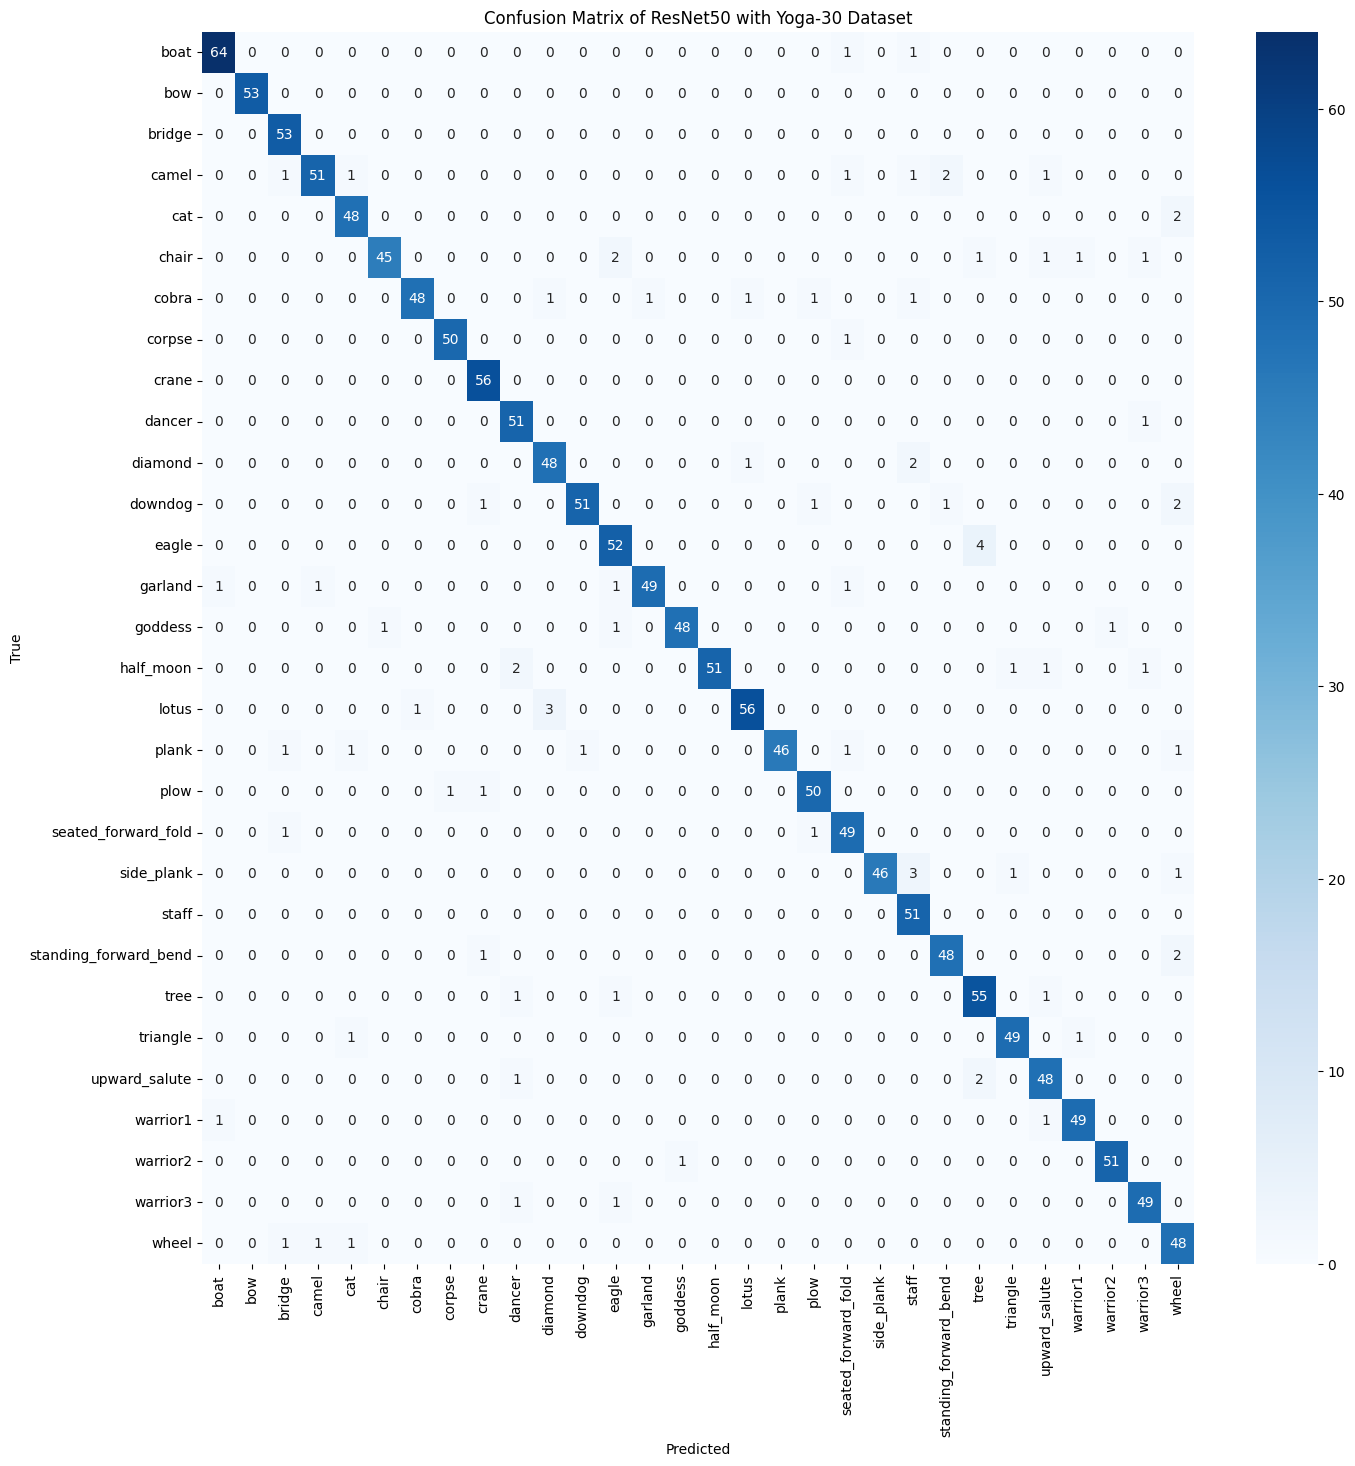

                       precision    recall  f1-score   support

                 boat       0.97      0.97      0.97        66
                  bow       1.00      1.00      1.00        53
               bridge       0.93      1.00      0.96        53
                camel       0.96      0.88      0.92        58
                  cat       0.92      0.96      0.94        50
                chair       0.98      0.88      0.93        51
                cobra       0.98      0.91      0.94        53
               corpse       0.98      0.98      0.98        51
                crane       0.95      1.00      0.97        56
               dancer       0.91      0.98      0.94        52
              diamond       0.92      0.94      0.93        51
              downdog       0.98      0.91      0.94        56
                eagle       0.90      0.93      0.91        56
              garland       0.98      0.92      0.95        53
              goddess       0.98      0.94      0.96  

In [46]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of ResNet50 with {dataset_name}')
plt.savefig('Confusion_Matrix_ResNet50.png')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=classes)
print(class_report)

In [47]:
with open('history_for_ResNet50.pkl', 'wb') as f:
    pickle.dump(history.history, f)

files_to_zip = ['history_for_ResNet50.pkl', 'weights_ResNet50.keras', 'Loss_Graph_ResNet50.png', 'Accuracy_Graph_ResNet50.png', 'Confusion_Matrix_ResNet50.png']
zip_filename = 'results_ResNet50.zip'

create_zip(files_to_zip, zip_filename)

In [48]:
!cp {zip_filename} {path_to_save}

# Vgg16 Model

In [49]:
def load_and_preprocess_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.keras.applications.vgg16.preprocess_input(img)
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {str(e)}")
        return None


def create_df(dir):
    df = pd.DataFrame(columns=['image_path', 'class_name', 'class_no', 'image'])
    class_names = sorted(os.listdir(dir))
    for class_name in class_names:
        class_path = os.path.join(dir, class_name)
        class_no = class_names.index(class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = load_and_preprocess_image(image_path)
            if img is not None:
                df.loc[len(df)] = [image_path, class_name, class_no, img]
            else:
                continue
    return df


def load_data(df):
    df.drop(columns=['image_path'], inplace=True)
    classes = df.pop('class_name').unique()
    x_images = df.pop('image')
    y = df.pop('class_no')
    y = keras.utils.to_categorical(y)
    return x_images, y, classes, df


train_df = create_df(train_dir)
test_df = create_df(test_dir)

X_train, y_train, classes, _ = load_data(train_df)
X_test, y_test, _, _ = load_data(test_df)

X_train = np.stack(X_train.values)
X_test = np.stack(X_test.values)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Error loading image /content/dataset/train/downdog/downdog_images_265.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_143.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_268.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error loading image /content/dataset/train/downdog/downdog_images_93.png: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [

In [50]:
vgg_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = False

model = tf.keras.Sequential([
    vgg_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               6422784   
                                                                 
 batch_normalization_108 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                

In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint_pth = 'weights_Vgg16.keras'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_pth, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/50
198/198 [==============================] - ETA: 0s - loss: 1.9853 - accuracy: 0.4638
Epoch 1: val_accuracy improved from -inf to 0.87422, saving model to weights_Vgg16.keras
198/198 [==============================] - 15s 56ms/step - loss: 1.9853 - accuracy: 0.4638 - val_loss: 0.5904 - val_accuracy: 0.8742
Epoch 2/50
197/198 [============================>.] - ETA: 0s - loss: 0.8538 - accuracy: 0.7844
Epoch 2: val_accuracy improved from 0.87422 to 0.91302, saving model to weights_Vgg16.keras
198/198 [==============================] - 7s 35ms/step - loss: 0.8524 - accuracy: 0.7846 - val_loss: 0.3953 - val_accuracy: 0.9130
Epoch 3/50
197/198 [============================>.] - ETA: 0s - loss: 0.4980 - accuracy: 0.8882
Epoch 3: val_accuracy improved from 0.91302 to 0.92178, saving model to weights_Vgg16.keras
198/198 [==============================] - 7s 35ms/step - loss: 0.4974 - accuracy: 0.8883 - val_loss: 0.2948 - val_accuracy: 0.9218
Epoch 4/50
197/198 [======================

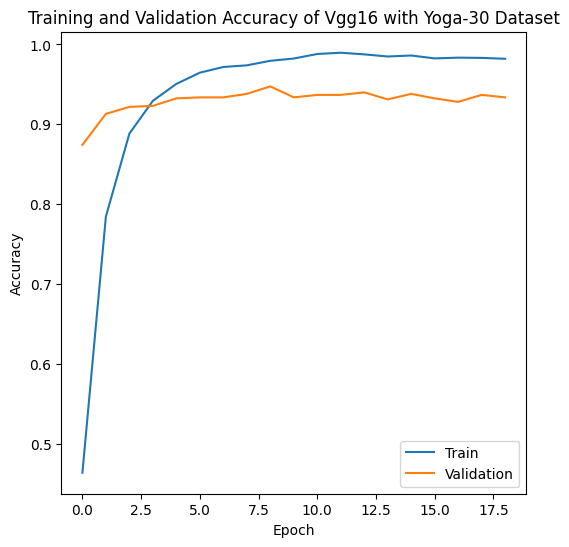

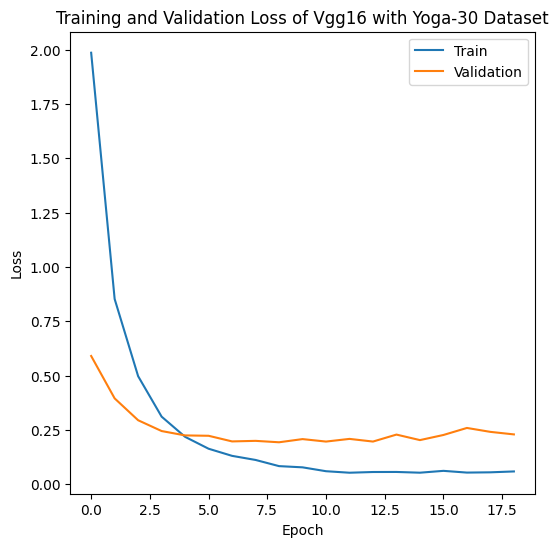

In [53]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Training and Validation Accuracy of Vgg16 with {dataset_name}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('Accuracy_Graph_Vgg16.png')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Training and Validation Loss of Vgg16 with {dataset_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Loss_Graph_Vgg16.png')
plt.show()

In [54]:
model = keras.models.load_model('weights_Vgg16.keras')
model.evaluate(X_test, y_test)


50/50 [==============================] - 2s 24ms/step - loss: 0.1934 - accuracy: 0.9474


[0.19343654811382294, 0.9474343061447144]

50/50 [==============================] - 1s 22ms/step


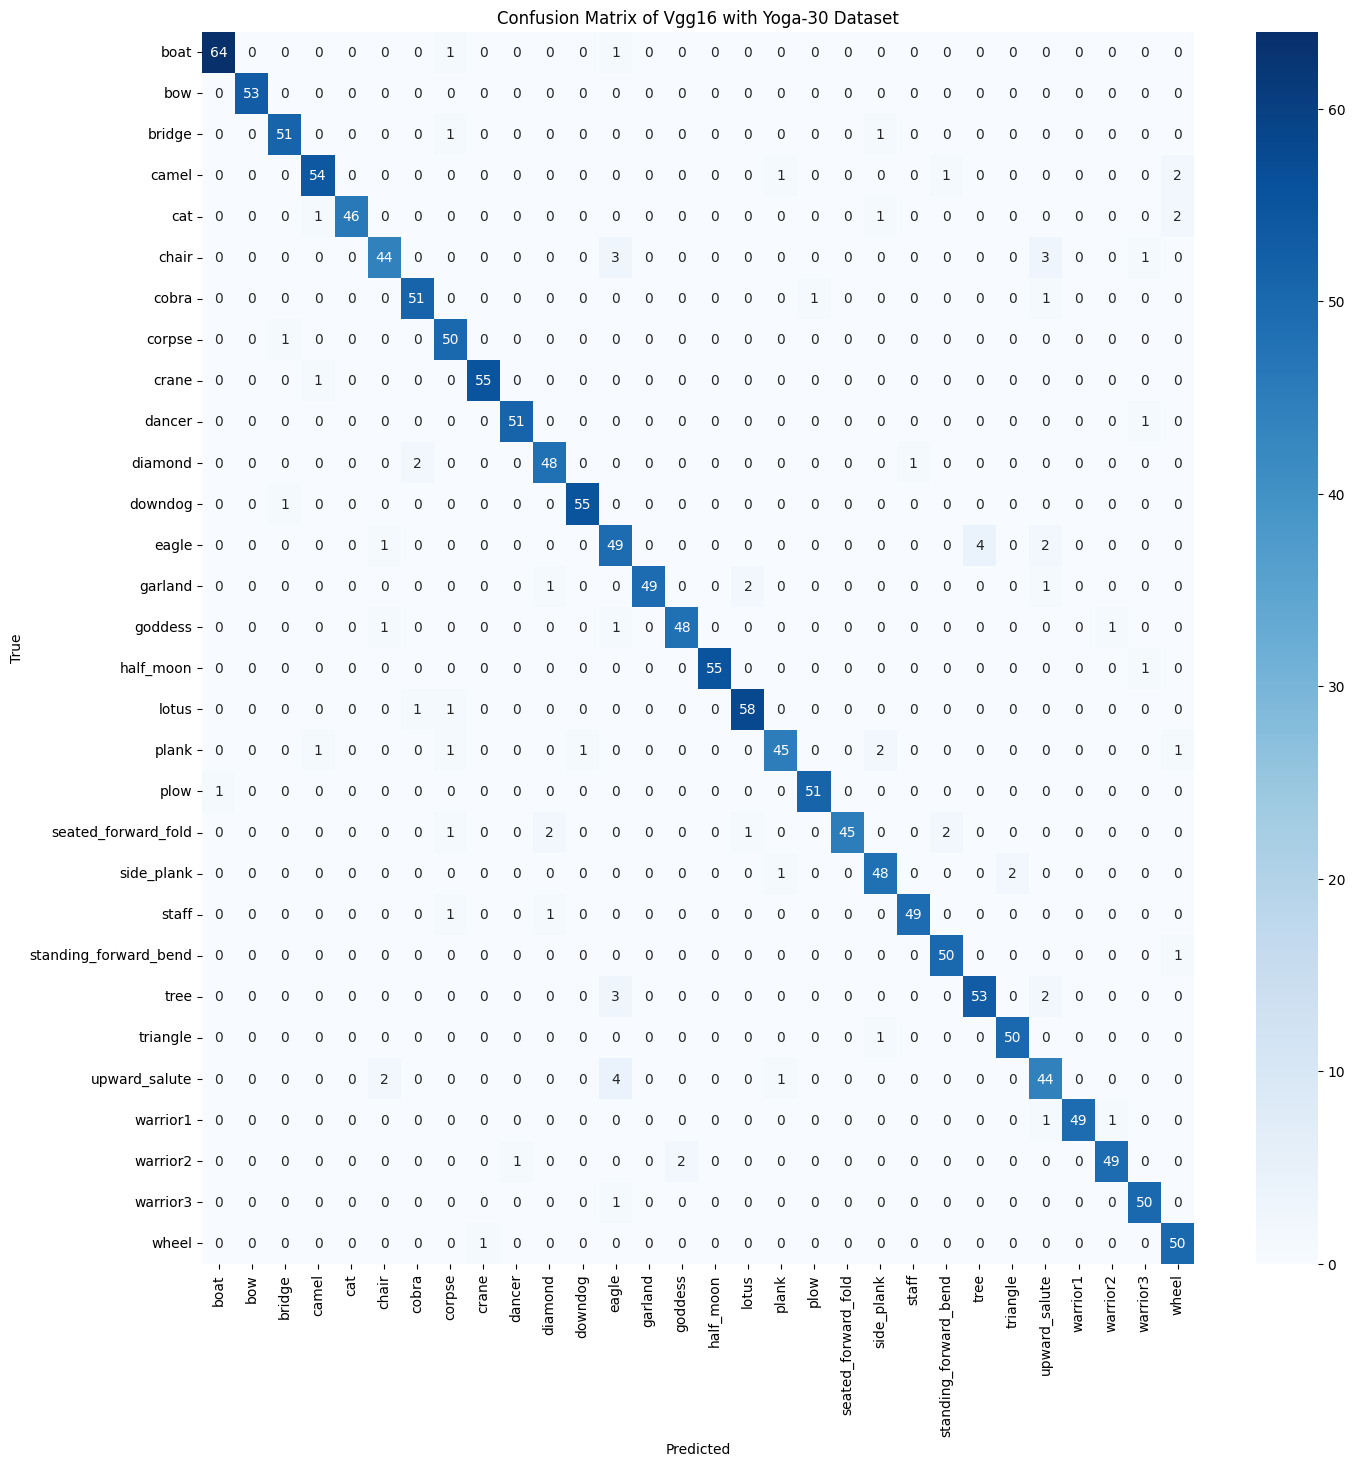

                       precision    recall  f1-score   support

                 boat       0.98      0.97      0.98        66
                  bow       1.00      1.00      1.00        53
               bridge       0.96      0.96      0.96        53
                camel       0.95      0.93      0.94        58
                  cat       1.00      0.92      0.96        50
                chair       0.92      0.86      0.89        51
                cobra       0.94      0.96      0.95        53
               corpse       0.89      0.98      0.93        51
                crane       0.98      0.98      0.98        56
               dancer       0.98      0.98      0.98        52
              diamond       0.92      0.94      0.93        51
              downdog       0.98      0.98      0.98        56
                eagle       0.79      0.88      0.83        56
              garland       1.00      0.92      0.96        53
              goddess       0.96      0.94      0.95  

In [55]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of Vgg16 with {dataset_name}')
plt.savefig('Confusion_Matrix_Vgg16.png')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=classes)
print(class_report)

In [56]:
with open('history_for_Vgg16.pkl', 'wb') as f:
    pickle.dump(history.history, f)

files_to_zip = ['weights_Vgg16.keras', 'history_for_Vgg16.pkl', 'Confusion_Matrix_Vgg16.png', 'Accuracy_Graph_Vgg16.png', 'Loss_Graph_Vgg16.png']
zip_filename = 'results_Vgg16.zip'

create_zip(files_to_zip, zip_filename)

In [57]:
!cp {zip_filename} {path_to_save}

# MoveNet Model

# Downloading MoveNet Model from TF Hub

In [58]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=5):
  """Runs detection on an input image.

  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.

  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """

  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)

  return person

Cloning into 'examples'...
remote: Enumerating objects: 23737, done.
remote: Counting objects: 100% (701/701), done.
remote: Compressing objects: 100% (428/428), done.
remote: Total 23737 (delta 230), reused 559 (delta 185), pack-reused 23036
Receiving objects: 100% (23737/23737), 44.19 MiB | 16.96 MiB/s, done.
Resolving deltas: 100% (12878/12878), done.


In [59]:
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.

  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.

  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])

  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)

  if close_figure:
    plt.close(fig)

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [60]:
class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""

  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()

    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )

  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file,
                                    delimiter=',',
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0

        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image,channels = 3)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image,channels = 3)
            image_height, image_width, channel = image.shape

          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)

          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person,
              close_figure=True, keep_input_size=True)

          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))

    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names

  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)

      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '')
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y',
                  bodypart.name + '_score'] for bodypart in BodyPart]
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i]
                  for i in range(len(header_name))}

    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

# Testing MoveNet Model

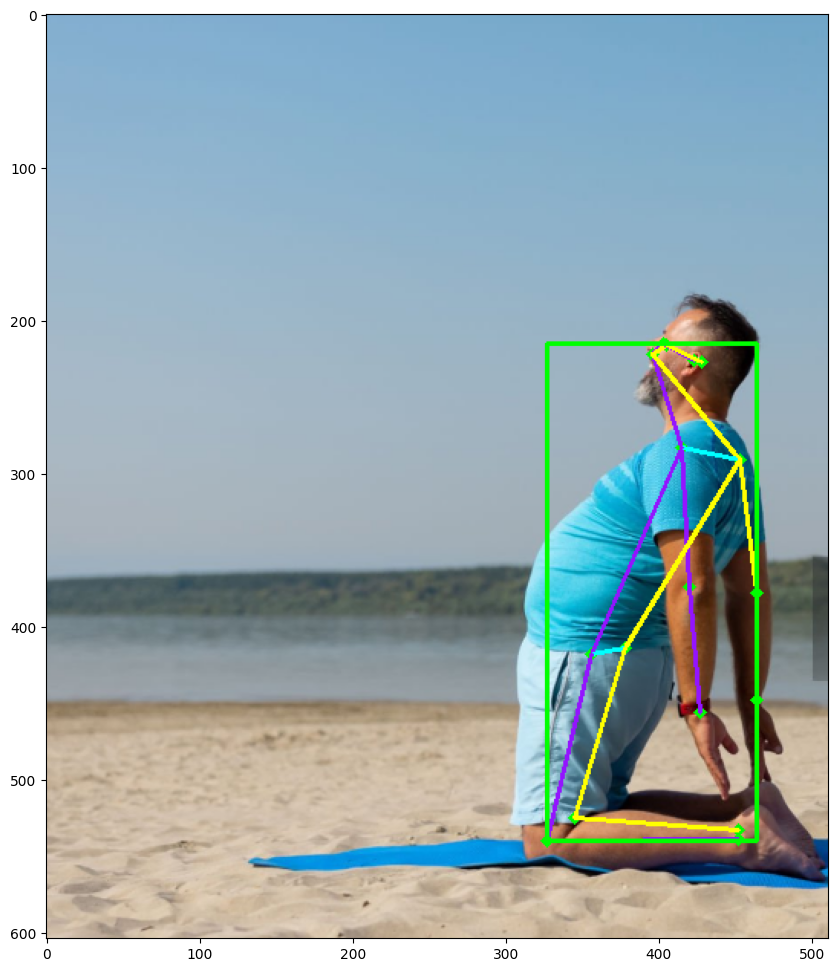

In [62]:
image = tf.io.read_file('/content/dataset/test/camel/camel_images_103.png')
image = tf.io.decode_jpeg(image, channels=3)
person = detect(image)
_ = draw_prediction_on_image(image.numpy(), person, crop_region=None,
                            close_figure=False, keep_input_size=True)

In [63]:
dataset_in = '/content/dataset/'

In [64]:
images_in_train_folder = os.path.join(dataset_in, 'train')
images_out_train_folder = 'poses_images_out_train'
csvs_out_train_path = 'train_data_MoveNet.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_train_folder,
    images_out_folder=images_out_train_folder,
    csvs_out_path=csvs_out_train_path,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing boat
  9%|▉         | 24/263 [00:04<00:43,  5.55it/s]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 263/263 [00:46<00:00,  5.62it/s]
Preprocessing bow
100%|██████████| 212/212 [00:33<00:00,  6.33it/s]
Preprocessing bridge
100%|██████████| 211/211 [00:22<00:00,  9.39it/s]
Preprocessing camel
100%|██████████| 230/230 [00:38<00:00,  5.96it/s]
Preprocessing cat
100%|██████████| 201/201 [00:25<00:00,  8.00it/s]
Preprocessing chair
100%|██████████| 201/201 [00:21<00:00,  9.31it/s]
Preprocessing cobra
100%|██████████| 211/211 [00:33<00:00,  6.32it/s]
Preprocessing corpse
100%|██████████| 201/201 [00:23<00:00,  8.69it/s]
Preprocessing crane
100%|██████████| 221/221 [00:27<00:00,  7.94it/s]
Preprocessing da

Skipped /content/dataset/train/boat/boat_images_100.png. No pose was confidentlly detected.
Skipped /content/dataset/train/boat/boat_images_126.png. No pose was confidentlly detected.
Skipped /content/dataset/train/boat/boat_images_128.png. No pose was confidentlly detected.
Skipped /content/dataset/train/boat/boat_images_130.png. No pose was confidentlly detected.
Skipped /content/dataset/train/boat/boat_images_203.png. No pose was confidentlly detected.
Skipped /content/dataset/train/boat/boat_images_223.png. No pose was confidentlly detected.
Skipped /content/dataset/train/boat/boat_images_249.png. No pose was confidentlly detected.
Skipped /content/dataset/train/boat/boat_images_267.png. No pose was confidentlly detected.
Skipped /content/dataset/train/boat/boat_images_285.png. No pose was confidentlly detected.
Skipped /content/dataset/train/boat/boat_images_295.png. No pose was confidentlly detected.
Skipped /content/dataset/train/boat/boat_images_31.png. No pose was confidentlly

In [65]:
images_in_test_folder = os.path.join(dataset_in, 'test')
images_out_test_folder = 'poses_images_out_test'
csvs_out_test_path = 'test_data_MoveNet.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_test_folder,
    images_out_folder=images_out_test_folder,
    csvs_out_path=csvs_out_test_path,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing boat
100%|██████████| 66/66 [00:11<00:00,  5.99it/s]
Preprocessing bow
100%|██████████| 53/53 [00:08<00:00,  6.57it/s]
Preprocessing bridge
100%|██████████| 53/53 [00:05<00:00,  9.98it/s]
Preprocessing camel
100%|██████████| 58/58 [00:18<00:00,  3.11it/s]
Preprocessing cat
100%|██████████| 51/51 [00:06<00:00,  8.20it/s]
Preprocessing chair
100%|██████████| 51/51 [00:05<00:00,  9.65it/s]
Preprocessing cobra
100%|██████████| 53/53 [00:09<00:00,  5.84it/s]
Preprocessing corpse
100%|██████████| 51/51 [00:05<00:00,  8.66it/s]
Preprocessing crane
100%|██████████| 56/56 [00:06<00:00,  8.39it/s]
Preprocessing dancer
100%|██████████| 52/52 [00:05<00:00,  8.82it/s]
Preprocessing diamond
100%|██████████| 51/51 [00:05<00:00,  9.24it/s]
Preprocessing downdog
100%|██████████| 56/56 [00:16<00:00,  3.39it/s]
Preprocessing eagle
100%|██████████| 56/56 [00:06<00:00,  8.01it/s]
Preprocessing garland
100%|██████████| 53/53 [00:08<00:00,  6.11it/s]
Preprocessing goddess
100%|██████████| 51/51

Skipped /content/dataset/test/boat/boat_images_308.png. No pose was confidentlly detected.
Skipped /content/dataset/test/boat/boat_images_62.png. No pose was confidentlly detected.
Skipped /content/dataset/test/bow/bow_images_140.png. No pose was confidentlly detected.
Skipped /content/dataset/test/bow/bow_images_190.png. No pose was confidentlly detected.
Skipped /content/dataset/test/bow/bow_images_92.png. No pose was confidentlly detected.
Skipped /content/dataset/test/camel/camel_images_239.png. No pose was confidentlly detected.
Skipped /content/dataset/test/camel/camel_images_25.png. No pose was confidentlly detected.
Skipped /content/dataset/test/camel/camel_images_34.png. No pose was confidentlly detected.
Skipped /content/dataset/test/cat/cat_images_210.png. Invalid image.
Skipped /content/dataset/test/chair/chair_images_177.png. No pose was confidentlly detected.
Skipped /content/dataset/test/chair/chair_images_242.png. No pose was confidentlly detected.
Skipped /content/data

In [66]:
!cp {csvs_out_train_path} {path_to_save}
!cp {csvs_out_test_path} {path_to_save}

In [67]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.

  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [68]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

X_train = X
y_train = y
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [69]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [76]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(256, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.3)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.3)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape_2 (Reshape)         (None, 17, 3)                0         ['input_9[0][0]']             
                                                                                                  
 tf.__operators__.getitem_2  (None, 17, 2)                0         ['reshape_2[0][0]']           
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.compat.v1.gather_18 (TF  (None, 2)                    0         ['tf.__operators__.getit

In [77]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights_MoveNet.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_test,y_test),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
363/377 [===========================>..] - ETA: 0s - loss: 2.5672 - accuracy: 0.2340
Epoch 1: val_accuracy improved from -inf to 0.50980, saving model to weights_MoveNet.keras
377/377 [==============================] - 3s 5ms/step - loss: 2.5407 - accuracy: 0.2395 - val_loss: 1.6279 - val_accuracy: 0.5098
Epoch 2/200
363/377 [===========================>..] - ETA: 0s - loss: 1.4525 - accuracy: 0.5296
Epoch 2: val_accuracy improved from 0.50980 to 0.75490, saving model to weights_MoveNet.keras
377/377 [==============================] - 1s 4ms/step - loss: 1.4427 - accuracy: 0.5322 - val_loss: 0.9558 - val_accuracy: 0.7549
Epoch 3/200
367/377 [============================>.] - ETA: 0s - loss: 1.0674 - accuracy: 0.6540
Epoch 3: val_accuracy improved from 0.75490 to 0.82222, saving model to weights_MoveNet.keras
377/377 [==============================] - 1s 4ms/step - loss: 1.0618 - accuracy: 0.6562 - val_loss: 0.7186 - val_accuracy: 0.8222
Epoch 4/200
369/377 [================

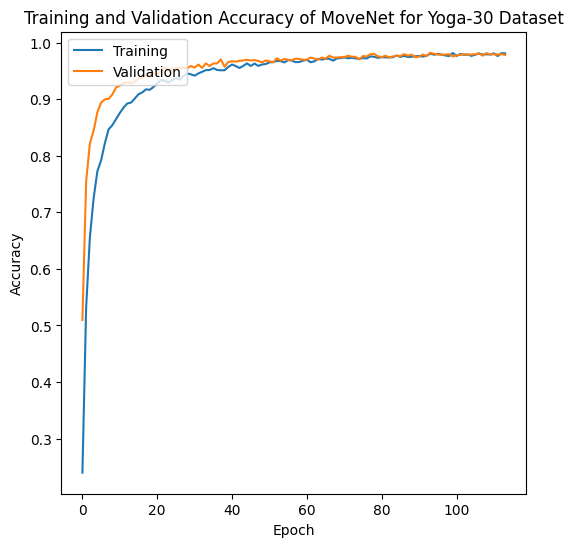

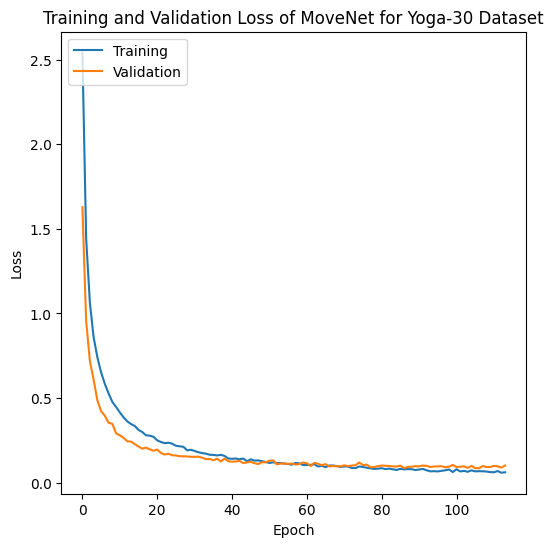

In [78]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Training and Validation Accuracy of MoveNet for {dataset_name}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig("Accuracy_Graph_MoveNet.png")
plt.show()

plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Training and Validation Loss of MoveNet for {dataset_name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig("Loss_Graph_MoveNet.png")
plt.show()

In [79]:
# Evaluate the model using the TEST dataset
model = keras.models.load_model('weights_MoveNet.keras')
loss, accuracy = model.evaluate(X_test, y_test)

48/48 [==============================] - 0s 2ms/step - loss: 0.0885 - accuracy: 0.9804


48/48 [==============================] - 0s 2ms/step


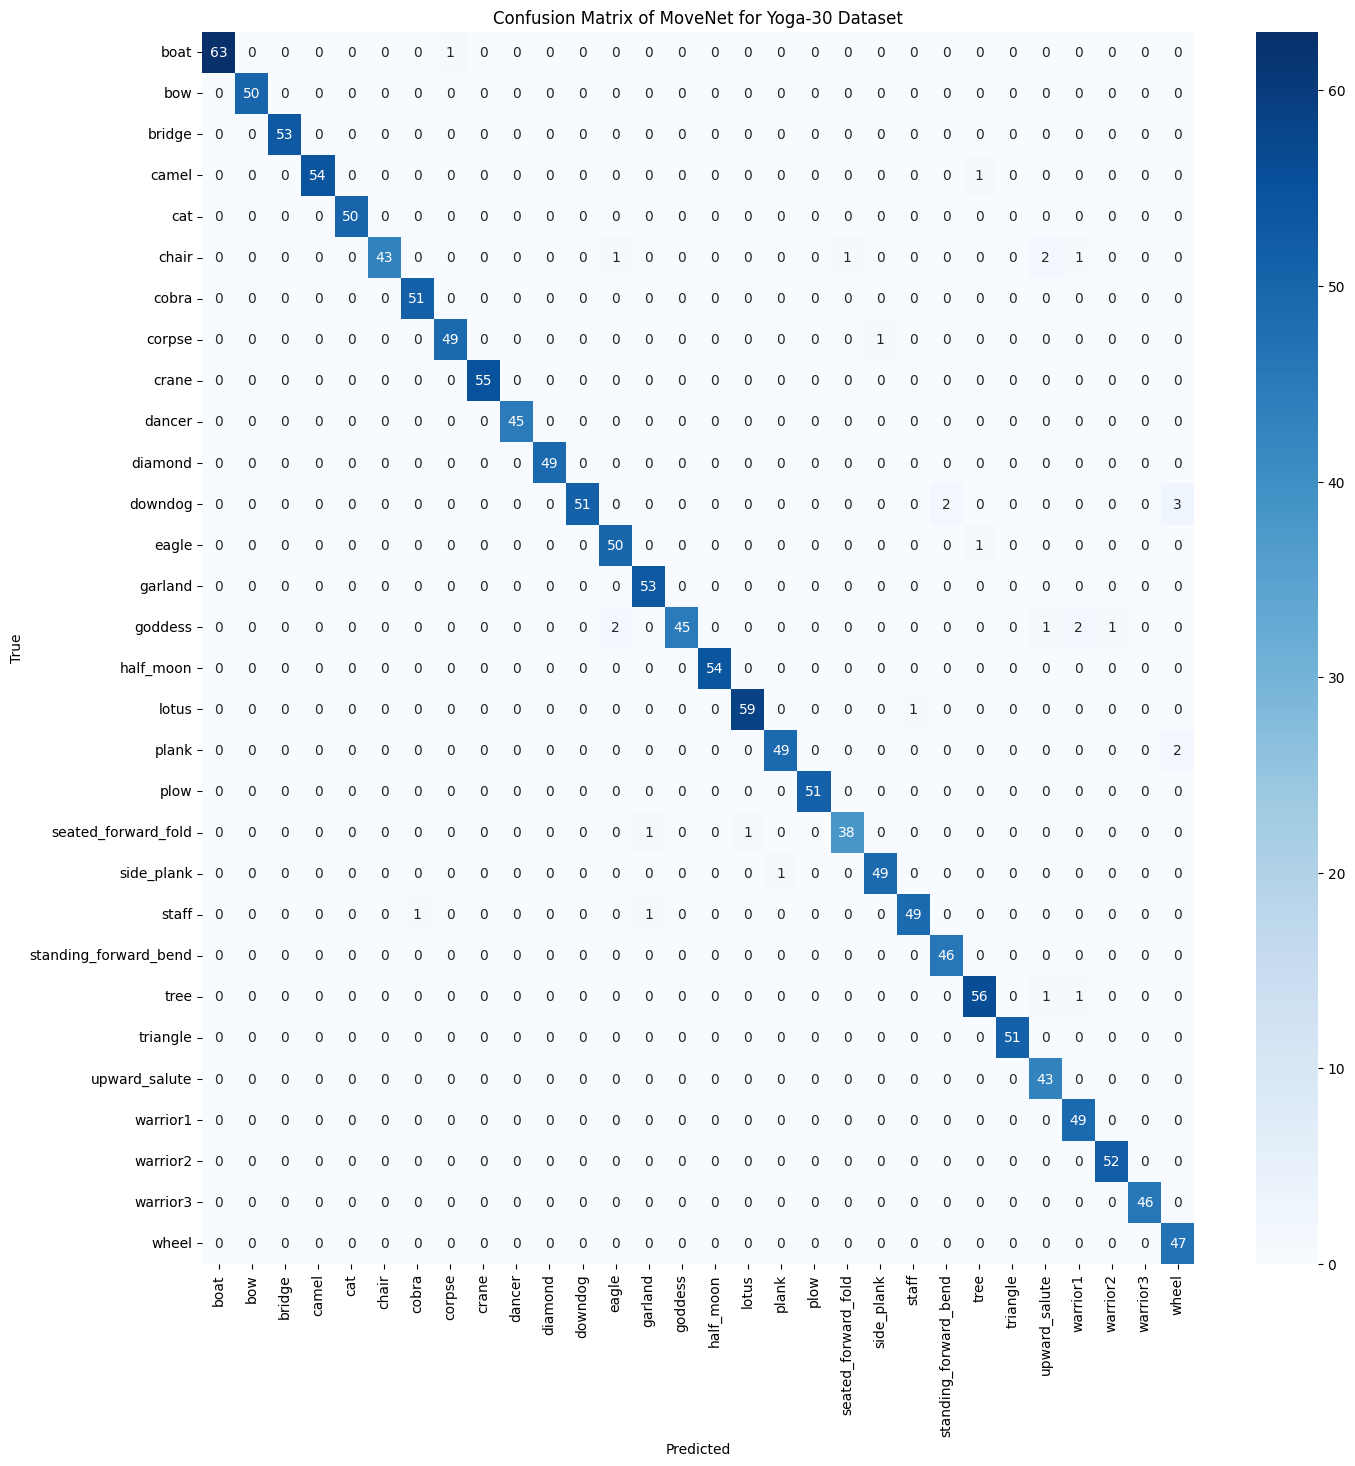

                       precision    recall  f1-score   support

                 boat       1.00      0.98      0.99        64
                  bow       1.00      1.00      1.00        50
               bridge       1.00      1.00      1.00        53
                camel       1.00      0.98      0.99        55
                  cat       1.00      1.00      1.00        50
                chair       1.00      0.90      0.95        48
                cobra       0.98      1.00      0.99        51
               corpse       0.98      0.98      0.98        50
                crane       1.00      1.00      1.00        55
               dancer       1.00      1.00      1.00        45
              diamond       1.00      1.00      1.00        49
              downdog       1.00      0.91      0.95        56
                eagle       0.94      0.98      0.96        51
              garland       0.96      1.00      0.98        53
              goddess       1.00      0.88      0.94  

In [80]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of MoveNet for {dataset_name}')
plt.savefig("Confusion_Matrix_MoveNet.png")
plt.show()

class_report = classification_report(y_true, y_pred, target_names=class_names)
print(class_report)

In [81]:
with open('history_for_MoveNet.pkl', 'wb') as f:
    pickle.dump(history, f)

files_to_zip = ['weights_MoveNet.keras', 'history_for_MoveNet.pkl', 'Confusion_Matrix_MoveNet.png','Accuracy_Graph_MoveNet.png','Loss_Graph_MoveNet.png' ]
zip_filename = 'results_MoveNet.zip'
create_zip(files_to_zip, zip_filename)

In [82]:
!cp {zip_filename} {path_to_save}

# MediaPipe Model

In [83]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
mp_drawing = mp.solutions.drawing_utils

<Figure size 1000x1000 with 0 Axes>

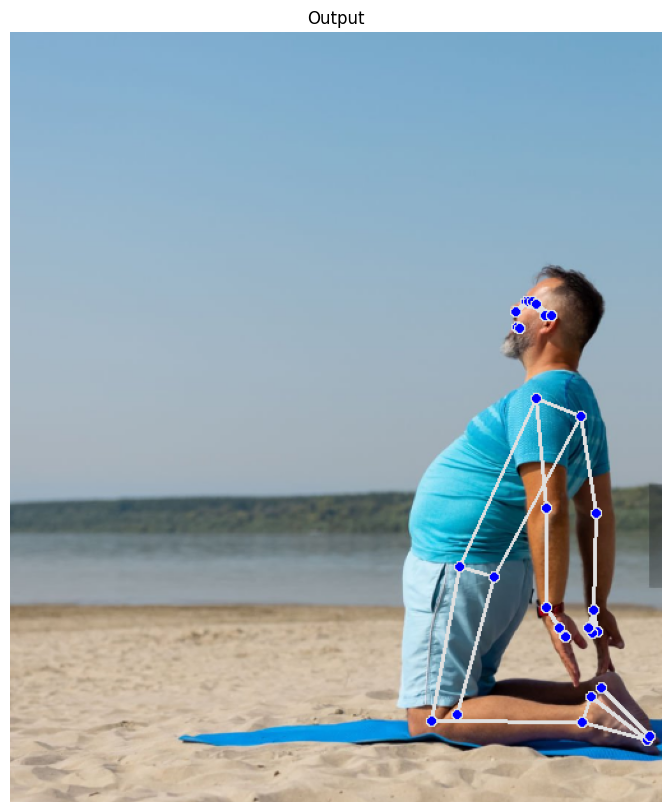

In [86]:
# Read an image from the specified path.
sample_img = cv2.imread('/content/dataset/test/camel/camel_images_103.png')
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
# Specify a size of the figure.
plt.figure(figsize = [10, 10])
results = pose.process(sample_img)
img_copy = sample_img.copy()

# Check if any landmarks are found.
if results.pose_landmarks:

    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)

    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display.
    plt.title("Output");plt.axis('off');plt.imshow(img_copy);plt.show()

In [87]:
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image,
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of dictionaries representing the detected landmarks with name, x, y, and score.
    '''

    # Create a copy of the input image.
    output_image = image.copy()

    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform the Pose Detection.
    results = pose.process(imageRGB)

    # Retrieve the height and width of the input image.
    height, width, _ = image.shape

    # Initialize a list to store the detected landmarks.
    landmarks = []

    # Check if any landmarks are detected.
    if results.pose_landmarks:
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)

        # Iterate over the detected landmarks.
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            # Append the landmark into the list as a dictionary with name, x, y, and score.
            landmarks.append({
                'name': mp_pose.PoseLandmark(idx).name,
                'x': landmark.x * width,
                'y': landmark.y * height,
                'score': landmark.visibility
            })

    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22, 22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    # Otherwise
    else:
        # Return the output image and the found landmarks.
        return output_image, landmarks

def landmarks_list_to_df(landmarks):
    # Convert the list of dictionaries to a DataFrame
    landmarks_df = pd.DataFrame(landmarks)

    # Initialize an empty list to store the transformed data
    transformed_data = []

    # Loop through each row of the DataFrame
    for index, row in landmarks_df.iterrows():
        transformed_row = dict()
        for landmark in row:
            if landmark is not None:
                name_x = landmark['name']+"_x"
                name_y = landmark['name']+'_y'
                name_score = landmark['name']+'_score'
                transformed_row[name_x] = landmark['x']
                transformed_row[name_y] = landmark['y']
                transformed_row[name_score] = landmark['score']
        transformed_data.append(transformed_row)

        # print()
    # Convert the transformed data list to a DataFrame
    landmarks_df_transformed = pd.DataFrame(transformed_data)
    return landmarks_df_transformed

def create_landmarks_dataframe(dataset_dir, pose):
    image_paths_train = []
    image_paths_test = []
    landmarks_train = []
    landmarks_test = []
    pose_name_train = []
    pose_name_test = []
    class_labels = {}
    class_label_counter = 0
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_path = os.path.join(root, file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                istrain = root.split(os.path.sep)[-2]
                o_img, landmark = detectPose(img, pose, display=False)
                if len(landmark)==0:
                    print(image_path)
                    print(landmark)
                    print()

                if landmark:
                    if istrain == 'train':
                        image_paths_train.append(image_path)
                        landmarks_train.append(landmark)
                        folder_name = root.split(os.path.sep)[-1]
                        pose_name_train.append(folder_name)
                        if folder_name not in class_labels:
                            class_labels[folder_name] = class_label_counter
                            class_label_counter += 1
                    else:
                        image_paths_test.append(image_path)
                        landmarks_test.append(landmark)
                        folder_name = root.split(os.path.sep)[-1]
                        pose_name_test.append(folder_name)
                        if folder_name not in class_labels:
                            class_labels[folder_name] = class_label_counter
                            class_label_counter += 1

    landmarks_train_df = landmarks_list_to_df(landmarks_train)
    landmarks_test_df = landmarks_list_to_df(landmarks_test)

    train_df = pd.DataFrame({'path': image_paths_train, 'pose_name': pose_name_train})
    test_df = pd.DataFrame({'path': image_paths_test, 'pose_name': pose_name_test})

    train_df['label'] = train_df['pose_name'].map(class_labels)
    test_df['label'] = test_df['pose_name'].map(class_labels)

    # # Combine the DataFrames horizontally
    train_combined_df = pd.concat([train_df, landmarks_train_df], axis=1)
    test_combined_df = pd.concat([test_df, landmarks_test_df], axis=1)

    return train_combined_df, test_combined_df


In [88]:
train_df, test_df = create_landmarks_dataframe('/content/dataset', pose)

/content/dataset/test/warrior1/warrior1_images_27.png
[]

/content/dataset/test/plank/plank_images_173.png
[]

/content/dataset/test/standing_forward_bend/standingforwardbend_images_160.png
[]

/content/dataset/test/standing_forward_bend/standingforwardbend_images_48.png
[]

/content/dataset/test/standing_forward_bend/standingforwardbend_images_40.png
[]

/content/dataset/test/standing_forward_bend/standingforwardbend_images_120.png
[]

/content/dataset/test/downdog/downdog_images_225.png
[]

/content/dataset/test/chair/chair_images_69.png
[]

/content/dataset/test/seated_forward_fold/seatedforwardfold_images_225.png
[]

/content/dataset/test/seated_forward_fold/seatedforwardfold_images_248.png
[]

/content/dataset/test/seated_forward_fold/seatedforwardfold_images_112.png
[]

/content/dataset/test/seated_forward_fold/seatedforwardfold_images_14.png
[]

/content/dataset/test/seated_forward_fold/seatedforwardfold_images_177.png
[]

/content/dataset/test/seated_forward_fold/seatedforwardf

In [90]:
train_df.to_csv('train_data_MediaPipe.csv', index=False)
test_df.to_csv('test_data_MediaPipe.csv', index=False)

In [91]:
!cp train_data_MediaPipe.csv {path_to_save}
!cp test_data_MediaPipe.csv {path_to_save}

In [92]:
def load_pose_landmarks(dataframe):
  """Loads a CSV created by MoveNetPreprocessor.

  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['path'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('pose_name').unique()

  # Extract the labels
  y = df_to_process.pop('label')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [93]:

X_train, y_train, class_names_train, _ = load_pose_landmarks(train_df)
X_test, y_test, class_names_test, _ = load_pose_landmarks(test_df)
# Combine the train and test class names to ensure consistency
class_names = np.unique(np.concatenate((class_names_train, class_names_test), axis=0))

# Build the neural network model
input_shape = X_train.shape[1:]
num_classes = len(class_names)


In [94]:

model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with learning rate
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 256)               25600     
                                                                 
 batch_normalization_110 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_111 (B  (None, 128)               512       
 atchNormalization)                                              
                                                                 
 dropout_19 (Dropout)        (None, 128)              

In [95]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
checkpoint_pth = 'weights_MediaPipe.keras'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_pth, monitor='val_accuracy', save_best_only=True, verbose = 1)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/100
186/191 [============================>.] - ETA: 0s - loss: 1.9285 - accuracy: 0.4862
Epoch 1: val_accuracy improved from -inf to 0.77332, saving model to weights_MediaPipe.keras
191/191 [==============================] - 4s 7ms/step - loss: 1.9126 - accuracy: 0.4901 - val_loss: 1.2394 - val_accuracy: 0.7733
Epoch 2/100
188/191 [============================>.] - ETA: 0s - loss: 1.0507 - accuracy: 0.7234
Epoch 2: val_accuracy did not improve from 0.77332
191/191 [==============================] - 1s 5ms/step - loss: 1.0483 - accuracy: 0.7244 - val_loss: 1.1466 - val_accuracy: 0.7157
Epoch 3/100
182/191 [===========================>..] - ETA: 0s - loss: 0.8630 - accuracy: 0.7653
Epoch 3: val_accuracy did not improve from 0.77332
191/191 [==============================] - 1s 6ms/step - loss: 0.8631 - accuracy: 0.7647 - val_loss: 0.8409 - val_accuracy: 0.7506
Epoch 4/100
189/191 [============================>.] - ETA: 0s - loss: 0.7489 - accuracy: 0.7894
Epoch 4: val_accuracy im

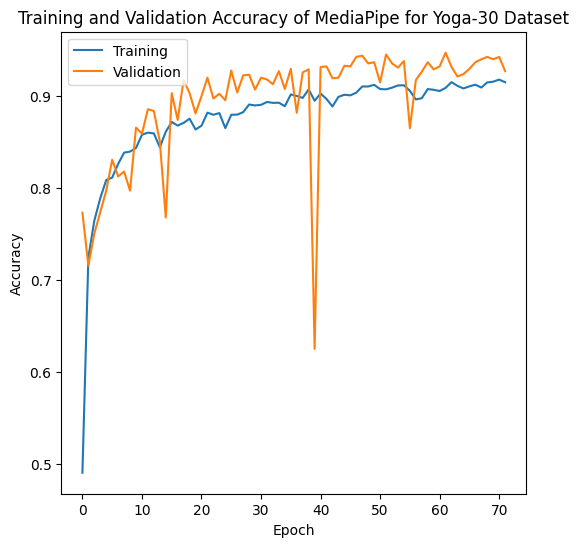

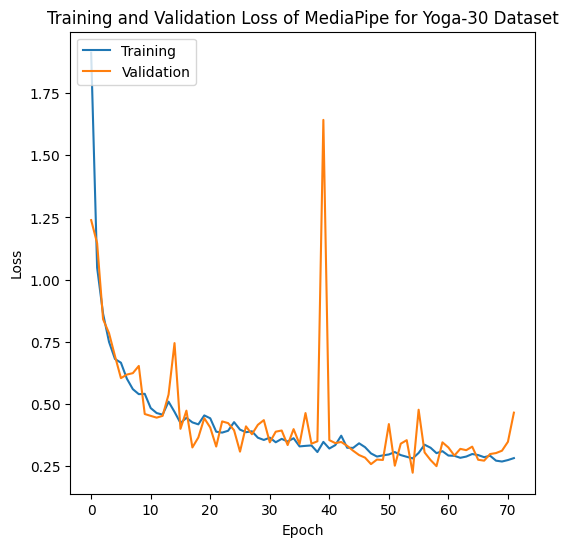

In [96]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Training and Validation Accuracy of MediaPipe for {dataset_name}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig("Accuracy_Graph_MediaPipe.png")
plt.show()

plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Training and Validation Loss of MediaPipe for {dataset_name}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig("Loss_Graph_MediaPipe.png")
plt.show()

In [97]:
model = keras.models.load_model('weights_MediaPipe.keras')
model.evaluate(X_test, y_test)

49/49 [==============================] - 0s 2ms/step - loss: 0.2924 - accuracy: 0.9475


[0.2923603057861328, 0.9475388526916504]

49/49 [==============================] - 0s 2ms/step


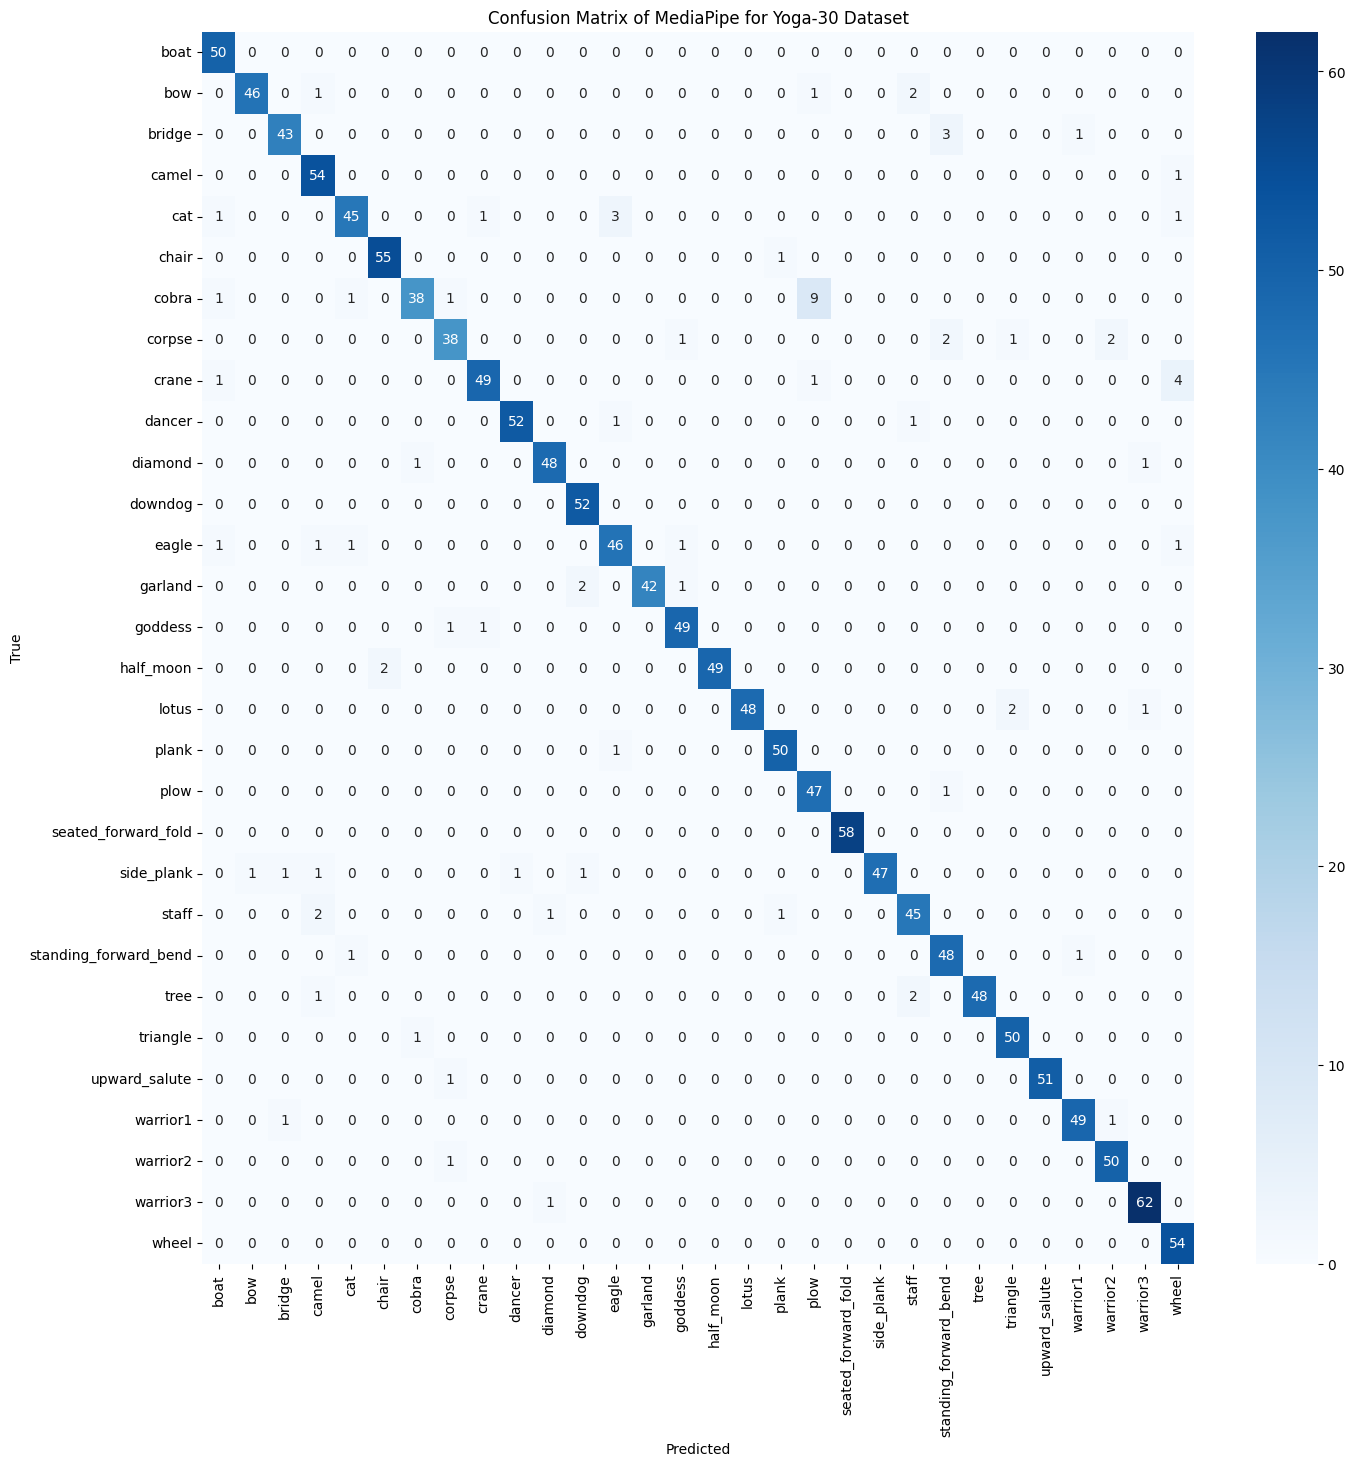

                       precision    recall  f1-score   support

                 boat       0.93      1.00      0.96        50
                  bow       0.98      0.92      0.95        50
               bridge       0.96      0.91      0.93        47
                camel       0.90      0.98      0.94        55
                  cat       0.94      0.88      0.91        51
                chair       0.96      0.98      0.97        56
                cobra       0.95      0.76      0.84        50
               corpse       0.90      0.86      0.88        44
                crane       0.96      0.89      0.92        55
               dancer       0.98      0.96      0.97        54
              diamond       0.96      0.96      0.96        50
              downdog       0.95      1.00      0.97        52
                eagle       0.90      0.90      0.90        51
              garland       1.00      0.93      0.97        45
              goddess       0.94      0.96      0.95  

In [98]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (16,16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of MediaPipe for {dataset_name}')
plt.savefig("Confusion_Matrix_MediaPipe.png")
plt.show()

class_report = classification_report(y_true, y_pred, target_names=class_names)
print(class_report)

In [99]:
with open('history_MediaPipe.pkl', 'wb') as f:
    pickle.dump(history.history, f)

files_to_zip = ['weights_MediaPipe.keras', 'history_MediaPipe.pkl', 'Confusion_Matrix_MediaPipe.png', 'Accuracy_Graph_MediaPipe.png', 'Loss_Graph_MediaPipe.png']
zip_filename = 'results_MediaPipe.zip'
create_zip(files_to_zip, zip_filename)

In [100]:
!cp {zip_filename} {path_to_save}

# Yolo Model

100%|██████████| 190M/190M [00:00<00:00, 218MB/s]



0: 1280x1088 1 person, 205.8ms
Speed: 13.4ms preprocess, 205.8ms inference, 638.9ms postprocess per image at shape (1, 3, 1280, 1088)


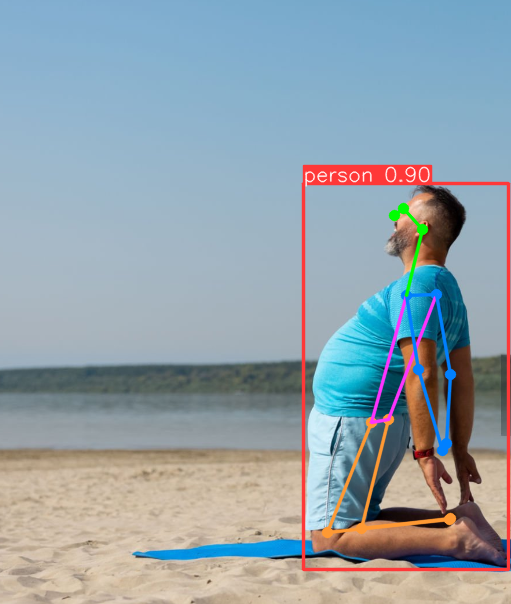

In [101]:
model = YOLO(model='yolov8x-pose-p6.pt')
image = cv2.imread('/content/dataset/test/camel/camel_images_103.png')
result = model.predict(image, save=False)[0]
result_keypoint = result.keypoints.xyn.cpu().numpy()[0]
Image.fromarray(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))

In [102]:
class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16

get_keypoint = GetKeypoint()

In [103]:
dataset_root_train = '/content/dataset/train'
dataset_root_test = '/content/dataset/test'
pose_list = sorted(os.listdir(dataset_root_train))
pose_list

['boat',
 'bow',
 'bridge',
 'camel',
 'cat',
 'chair',
 'cobra',
 'corpse',
 'crane',
 'dancer',
 'diamond',
 'downdog',
 'eagle',
 'garland',
 'goddess',
 'half_moon',
 'lotus',
 'plank',
 'plow',
 'seated_forward_fold',
 'side_plank',
 'staff',
 'standing_forward_bend',
 'tree',
 'triangle',
 'upward_salute',
 'warrior1',
 'warrior2',
 'warrior3',
 'wheel']

In [104]:
def extract_keypoint(keypoint):
    # nose
    nose_x, nose_y = keypoint[get_keypoint.NOSE]
    # eye
    left_eye_x, left_eye_y = keypoint[get_keypoint.LEFT_EYE]
    right_eye_x, right_eye_y = keypoint[get_keypoint.RIGHT_EYE]
    # ear
    left_ear_x, left_ear_y = keypoint[get_keypoint.LEFT_EAR]
    right_ear_x, right_ear_y = keypoint[get_keypoint.RIGHT_EAR]
    # shoulder
    left_shoulder_x, left_shoulder_y = keypoint[get_keypoint.LEFT_SHOULDER]
    right_shoulder_x, right_shoulder_y = keypoint[get_keypoint.RIGHT_SHOULDER]
    # elbow
    left_elbow_x, left_elbow_y = keypoint[get_keypoint.LEFT_ELBOW]
    right_elbow_x, right_elbow_y = keypoint[get_keypoint.RIGHT_ELBOW]
    # wrist
    left_wrist_x, left_wrist_y = keypoint[get_keypoint.LEFT_WRIST]
    right_wrist_x, right_wrist_y = keypoint[get_keypoint.RIGHT_WRIST]
    # hip
    left_hip_x, left_hip_y = keypoint[get_keypoint.LEFT_HIP]
    right_hip_x, right_hip_y = keypoint[get_keypoint.RIGHT_HIP]
    # knee
    left_knee_x, left_knee_y = keypoint[get_keypoint.LEFT_KNEE]
    right_knee_x, right_knee_y = keypoint[get_keypoint.RIGHT_KNEE]
    # ankle
    left_ankle_x, left_ankle_y = keypoint[get_keypoint.LEFT_ANKLE]
    right_ankle_x, right_ankle_y = keypoint[get_keypoint.RIGHT_ANKLE]

    return [
        nose_x, nose_y,
        left_eye_x, left_eye_y,
        right_eye_x, right_eye_y,
        left_ear_x, left_ear_y,
        right_ear_x, right_ear_y,
        left_shoulder_x, left_shoulder_y,
        right_shoulder_x, right_shoulder_y,
        left_elbow_x, left_elbow_y,
        right_elbow_x, right_elbow_y,
        left_wrist_x, left_wrist_y,
        right_wrist_x, right_wrist_y,
        left_hip_x, left_hip_y,
        right_hip_x, right_hip_y,
        left_knee_x, left_knee_y,
        right_knee_x, right_knee_y,
        left_ankle_x, left_ankle_y,
        right_ankle_x, right_ankle_y
    ]

In [106]:
dataset_csv_train = []
for pose in pose_list:
    # Using a set to store valid image extensions
    valid_extensions = {'jpg', 'jpeg', 'png', 'bmp'}

    # List all files in the directory
    image_path_list = []
    for ext in valid_extensions:
        image_path_list.extend(glob.glob(f'{dataset_root_train}/{pose}/*.{ext}'))

    for image_path in image_path_list:
        # get image_name
        image_name = image_path.split('/')[-1]
        # read numpy image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Unable to read image: {image_path}")
            continue  # Skip to the next image if reading fails

        # get height width image
        height, width = image.shape[:2]

        # detect pose using yolov8-pose
        results = model.predict(image, save=False)[0]
        results_keypoint = results.keypoints.xyn.cpu().numpy()

        # Check if only one person is detected
        if len(results_keypoint) == 1:
            result_keypoint = results_keypoint[0]
            if len(result_keypoint) == 17:
                keypoint_list = extract_keypoint(result_keypoint)

                # insert image_name, label at index 0, 1
                keypoint_list.insert(0, image_path)
                keypoint_list.insert(1, pose)
                dataset_csv_train.append(keypoint_list)
        else:
            print("------------------------------------------------------------------------")
            print(f"More than one person detected in image: {image_path}. Ignoring pose landmarks.")
            print("------------------------------------------------------------------------")



Streaming output truncated to the last 5000 lines.
0: 1088x1280 1 person, 27.3ms
Speed: 6.8ms preprocess, 27.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1088, 1280)

0: 1280x896 1 person, 28.6ms
Speed: 5.4ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 896)

0: 1280x896 1 person, 26.8ms
Speed: 5.8ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 896)

0: 1280x1024 1 person, 28.3ms
Speed: 6.0ms preprocess, 28.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1024)

0: 960x1280 1 person, 29.9ms
Speed: 6.1ms preprocess, 29.9ms inference, 1.8ms postprocess per image at shape (1, 3, 960, 1280)

0: 1280x1280 1 person, 28.5ms
Speed: 8.1ms preprocess, 28.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 1 person, 27.7ms
Speed: 8.2ms preprocess, 27.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x896 1 person, 28.1ms
Speed: 5.8ms pre

In [107]:
dataset_csv_test = []
for pose in pose_list:
    # Using a set to store valid image extensions
    valid_extensions = {'jpg', 'jpeg', 'png', 'bmp'}

    # List all files in the directory
    image_path_list = []
    for ext in valid_extensions:
        image_path_list.extend(glob.glob(f'{dataset_root_test}/{pose}/*.{ext}'))

    for image_path in image_path_list:
        # get image_name
        image_name = image_path.split('/')[-1]
        # read numpy image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Unable to read image: {image_path}")
            continue  # Skip to the next image if reading fails

        # get height width image
        height, width = image.shape[:2]

        # detect pose using yolov8-pose
        results = model.predict(image, save=False)[0]
        results_keypoint = results.keypoints.xyn.cpu().numpy()

        # Check if only one person is detected
        if len(results_keypoint) == 1:
            result_keypoint = results_keypoint[0]
            if len(result_keypoint) == 17:
                keypoint_list = extract_keypoint(result_keypoint)

                # insert image_name, label at index 0, 1
                keypoint_list.insert(0, image_path)
                keypoint_list.insert(1, pose)
                dataset_csv_test.append(keypoint_list)
        else:
            print("------------------------------------------------------------------------")
            print(f"More than one person detected in image: {image_path}. Ignoring pose landmarks.")
            print("------------------------------------------------------------------------")



0: 896x1280 1 person, 29.0ms
Speed: 6.9ms preprocess, 29.0ms inference, 2.2ms postprocess per image at shape (1, 3, 896, 1280)

0: 1088x1280 1 person, 29.5ms
Speed: 7.5ms preprocess, 29.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1088, 1280)

0: 1024x1280 1 person, 29.9ms
Speed: 7.5ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1280)

0: 832x1280 1 person, 29.3ms
Speed: 6.7ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 832, 1280)

0: 896x1280 1 person, 29.3ms
Speed: 7.2ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 896, 1280)

0: 896x1280 1 person, 28.5ms
Speed: 6.1ms preprocess, 28.5ms inference, 1.6ms postprocess per image at shape (1, 3, 896, 1280)

0: 960x1280 1 person, 29.0ms
Speed: 7.2ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 960, 1280)

0: 1088x1280 1 person, 29.7ms
Speed: 8.3ms preprocess, 29.7ms inference, 1.6ms postprocess per imag

In [108]:

# Create a list of column headings
column_headings = ['image_path', 'label',
                   'nose_x', 'nose_y',
                   'left_eye_x', 'left_eye_y',
                   'right_eye_x', 'right_eye_y',
                   'left_ear_x', 'left_ear_y',
                   'right_ear_x', 'right_ear_y',
                   'left_shoulder_x', 'left_shoulder_y',
                   'right_shoulder_x', 'right_shoulder_y',
                   'left_elbow_x', 'left_elbow_y',
                   'right_elbow_x', 'right_elbow_y',
                   'left_wrist_x', 'left_wrist_y',
                   'right_wrist_x', 'right_wrist_y',
                   'left_hip_x', 'left_hip_y',
                   'right_hip_x', 'right_hip_y',
                   'left_knee_x', 'left_knee_y',
                   'right_knee_x', 'right_knee_y',
                   'left_ankle_x', 'left_ankle_y',
                   'right_ankle_x', 'right_ankle_y']

with open('train_data_yolo.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the column headings as the first row
    writer.writerow(column_headings)

    # Write the list data to the CSV file
    writer.writerows(dataset_csv_train)



# Create a list of column headings
column_headings = ['image_path', 'label',
                   'nose_x', 'nose_y',
                   'left_eye_x', 'left_eye_y',
                   'right_eye_x', 'right_eye_y',
                   'left_ear_x', 'left_ear_y',
                   'right_ear_x', 'right_ear_y',
                   'left_shoulder_x', 'left_shoulder_y',
                   'right_shoulder_x', 'right_shoulder_y',
                   'left_elbow_x', 'left_elbow_y',
                   'right_elbow_x', 'right_elbow_y',
                   'left_wrist_x', 'left_wrist_y',
                   'right_wrist_x', 'right_wrist_y',
                   'left_hip_x', 'left_hip_y',
                   'right_hip_x', 'right_hip_y',
                   'left_knee_x', 'left_knee_y',
                   'right_knee_x', 'right_knee_y',
                   'left_ankle_x', 'left_ankle_y',
                   'right_ankle_x', 'right_ankle_y']

with open('test_data_yolo.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the column headings as the first row
    writer.writerow(column_headings)

    # Write the list data to the CSV file
    writer.writerows(dataset_csv_test)


In [109]:
train_df = pd.read_csv('train_data_yolo.csv')
test_df = pd.read_csv('test_data_yolo.csv')

train_df.to_csv('train_data_yolo.csv', index=False)
test_df.to_csv('test_data_yolo.csv', index=False)

In [110]:
!cp train_data_yolo.csv {path_to_save}
!cp test_data_yolo.csv {path_to_save}

In [111]:
train_df = train_df.drop('image_path', axis=1)
test_df = test_df.drop('image_path', axis=1)
encoder = LabelEncoder()
y_label_train = train_df['label']
y_train = encoder.fit_transform(y_label_train)
y_label_test = test_df['label']
y_test = encoder.fit_transform(y_label_test)
train_df = train_df.drop('label',axis=1)
X_train = train_df
test_df = test_df.drop('label',axis=1)
X_test = test_df
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [112]:
model = tf.keras.models.Sequential()
model.add(layers.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(pose_list), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 256)               8960      
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 30)                1950      
                                                                 
Total params: 52062 (203.37 KB)
Trainable params: 52062 (203.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint_pth = 'weights_yolo.keras'
checkpoint = ModelCheckpoint(checkpoint_pth, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])


Epoch 1/100
187/191 [============================>.] - ETA: 0s - loss: 2.5301 - accuracy: 0.2878
Epoch 1: val_accuracy improved from -inf to 0.50550, saving model to weights_yolo.keras
191/191 [==============================] - 2s 5ms/step - loss: 2.5126 - accuracy: 0.2931 - val_loss: 1.6307 - val_accuracy: 0.5055
Epoch 2/100
188/191 [============================>.] - ETA: 0s - loss: 1.3226 - accuracy: 0.6027
Epoch 2: val_accuracy improved from 0.50550 to 0.67249, saving model to weights_yolo.keras
191/191 [==============================] - 1s 3ms/step - loss: 1.3178 - accuracy: 0.6042 - val_loss: 1.1368 - val_accuracy: 0.6725
Epoch 3/100
184/191 [===========================>..] - ETA: 0s - loss: 0.9909 - accuracy: 0.7040
Epoch 3: val_accuracy improved from 0.67249 to 0.73463, saving model to weights_yolo.keras
191/191 [==============================] - 1s 3ms/step - loss: 0.9844 - accuracy: 0.7054 - val_loss: 0.8856 - val_accuracy: 0.7346
Epoch 4/100
189/191 [=========================

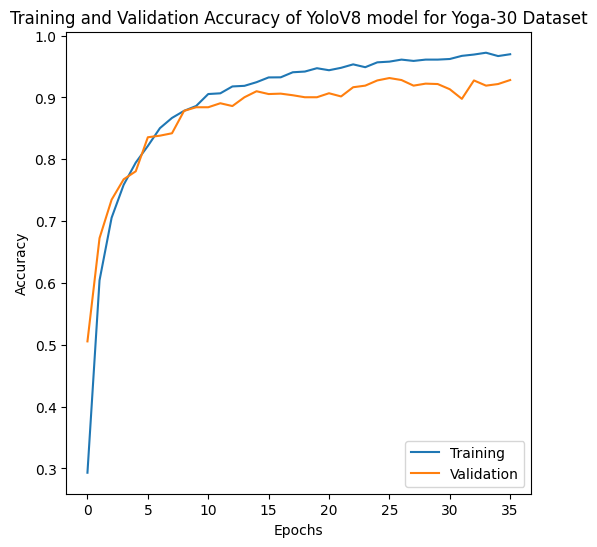

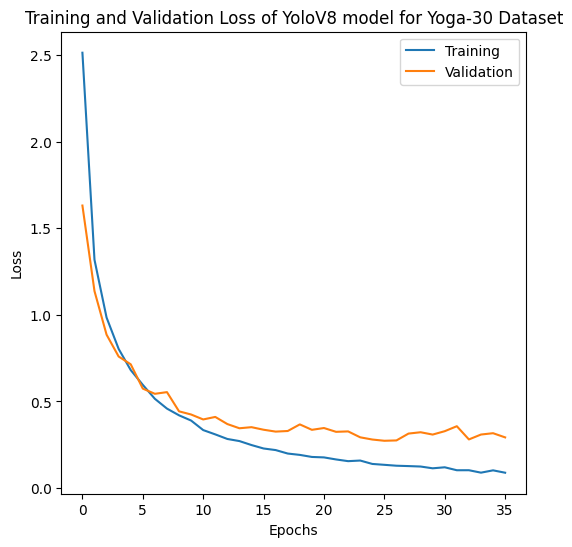

In [114]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f"Training and Validation Accuracy of YoloV8 model for {dataset_name}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig("Accuracy_Graph_Yolo.png")
plt.show()

plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"Training and Validation Loss of YoloV8 model for {dataset_name}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig("Loss_Graph_Yolo.png")
plt.show()

In [115]:
model.evaluate(X_test, y_test)

49/49 [==============================] - 0s 2ms/step - loss: 0.2928 - accuracy: 0.9282


[0.29278045892715454, 0.9281553626060486]

49/49 [==============================] - 0s 1ms/step


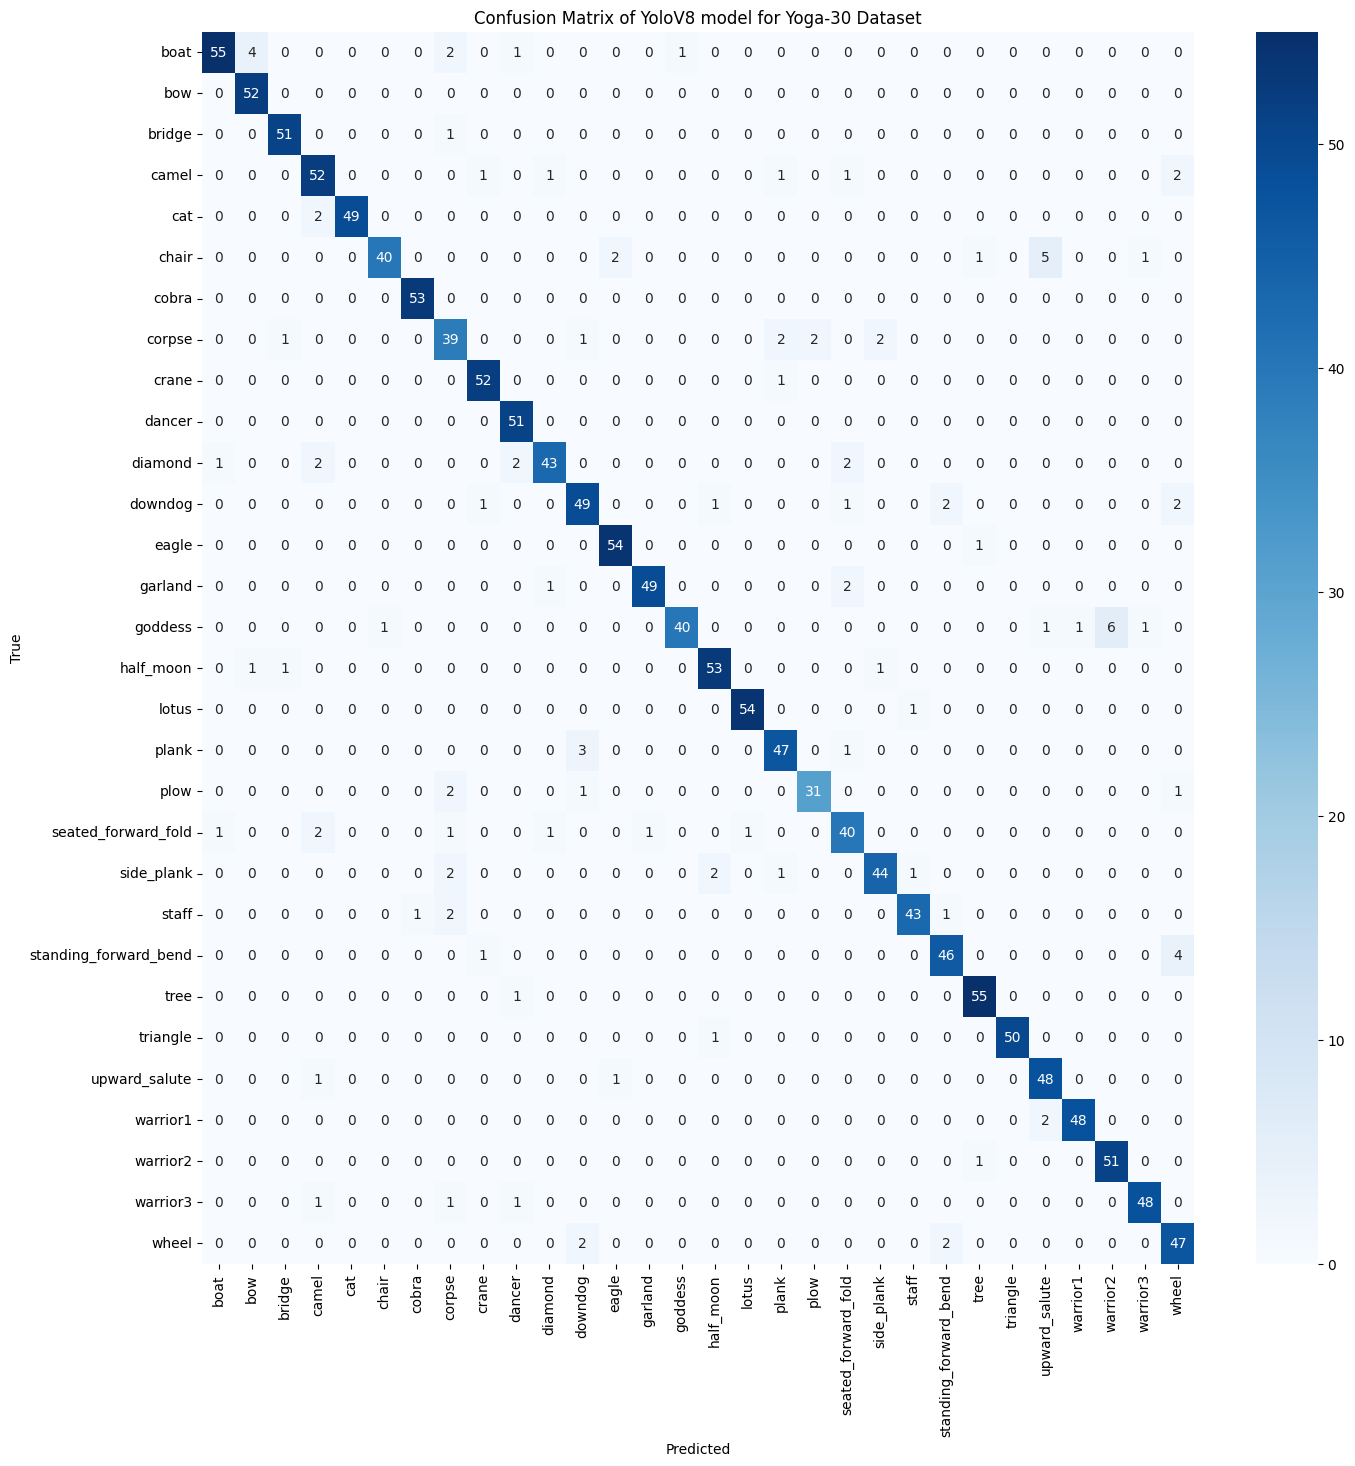

                       precision    recall  f1-score   support

                 boat       0.96      0.87      0.92        63
                  bow       0.91      1.00      0.95        52
               bridge       0.96      0.98      0.97        52
                camel       0.87      0.90      0.88        58
                  cat       1.00      0.96      0.98        51
                chair       0.98      0.82      0.89        49
                cobra       0.98      1.00      0.99        53
               corpse       0.78      0.83      0.80        47
                crane       0.95      0.98      0.96        53
               dancer       0.91      1.00      0.95        51
              diamond       0.93      0.86      0.90        50
              downdog       0.88      0.88      0.88        56
                eagle       0.95      0.98      0.96        55
              garland       0.98      0.94      0.96        52
              goddess       0.98      0.80      0.88  

In [117]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
class_names = encoder.classes_

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"Confusion Matrix of YoloV8 model for {dataset_name}")
plt.savefig("Confusion_Matrix_Yolo.png")
plt.show()

class_report = classification_report(y_test, y_pred, target_names=class_names)
print(class_report)

In [118]:
with open('history_for_yolo.pkl', 'wb') as f:
    pickle.dump(history.history, f)
files_to_zip = ['weights_yolo.keras', 'history_for_yolo.pkl', 'Accuracy_Graph_Yolo.png', 'Loss_Graph_Yolo.png', 'Confusion_Matrix_Yolo.png']
zip_filename = 'results_yolo.zip'
create_zip(files_to_zip, zip_filename)

In [119]:
!cp {zip_filename} {path_to_save}